# Análise do E-commerce Brasileiro Olist com Técnicas Multivariadas

## 1. Introdução

O e-commerce brasileiro teve um crescimento explosivo nos últimos anos. Compreender os padrões de compra, comportamento do cliente e fatores que influenciam o sucesso de vendas é essencial para empresas que buscam competir neste mercado.

Neste estudo, usaremos o dataset da Olist, uma plataforma brasileira de e-commerce que conecta pequenos negócios de todo o Brasil a canais de venda. O conjunto de dados contém informações sobre 100 mil pedidos realizados entre 2016 e 2018.

In [3]:
import kagglehub
import shutil
import os

# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)

# Define the destination directory
destination = "../data"

# Ensure the destination directory exists
os.makedirs(destination, exist_ok=True)

# Copy the dataset to the destination directory
shutil.copytree(path, destination, dirs_exist_ok=True)

print(f"Dataset copied to {destination}")

d:\olist-analytics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 42.6M/42.6M [00:04<00:00, 9.99MB/s]

Extracting files...


Path to dataset files: C:\Users\Raíssa\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2
Dataset copied to ../data


## 2. Importação e Preparação dos Dados

Vamos importar as bibliotecas necessárias e carregar os datasets da Olist.

In [7]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from scipy import stats
import datetime as dt
import warnings

# Configurações de visualização
# plt.style.use('seaborn-v0_8-whitegrid')
# plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [8]:
# Carregar os datasets
customers = pd.read_csv('../data/olist_customers_dataset.csv')
geolocation = pd.read_csv('../data/olist_geolocation_dataset.csv')
order_items = pd.read_csv('../data/olist_order_items_dataset.csv')
payments = pd.read_csv('../data/olist_order_payments_dataset.csv')
reviews = pd.read_csv('../data/olist_order_reviews_dataset.csv')
orders = pd.read_csv('../data/olist_orders_dataset.csv')
products = pd.read_csv('../data/olist_products_dataset.csv')
sellers = pd.read_csv('../data/olist_sellers_dataset.csv')
category_translation = pd.read_csv('../data/product_category_name_translation.csv')

# Verificar os datasets importados
print(f"Customers shape: {customers.shape}")
print(f"Geolocation shape: {geolocation.shape}")
print(f"Order Items shape: {order_items.shape}")
print(f"Payments shape: {payments.shape}")
print(f"Reviews shape: {reviews.shape}")
print(f"Orders shape: {orders.shape}")
print(f"Products shape: {products.shape}")
print(f"Sellers shape: {sellers.shape}")
print(f"Category Translation shape: {category_translation.shape}")

Customers shape: (99441, 5)
Geolocation shape: (1000163, 5)
Order Items shape: (112650, 7)
Payments shape: (103886, 5)
Reviews shape: (99224, 7)
Orders shape: (99441, 8)
Products shape: (32951, 9)
Sellers shape: (3095, 4)
Category Translation shape: (71, 2)


### 2.1 Preparação dos Dados para Análise

Vamos juntar e transformar os dados para prepará-los para a análise multivariada. Primeiro, vamos converter as colunas de data para o formato datetime.

In [9]:
# Converter colunas de data para datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                'order_delivered_customer_date', 'order_estimated_delivery_date']

for col in date_columns:
    orders[col] = pd.to_datetime(orders[col])

reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])
reviews['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'])

In [10]:
# Merging data para análise
# Primeiramente, juntamos orders com customers para ter informações de localização do cliente
orders_customers = pd.merge(orders, customers, on='customer_id')

# Adicionamos informações de pagamento
orders_payments = pd.merge(orders_customers, payments, on='order_id')

# Adicionamos avaliações
# Como pode haver múltiplas avaliações por pedido, vamos pegar a média ou a última
reviews_aggregated = reviews.groupby('order_id').agg({
    'review_score': 'mean',
    'review_comment_message': lambda x: ' '.join(x.dropna()),
    'review_creation_date': 'max'
}).reset_index()

# Garantindo que a pontuação seja um inteiro
reviews_aggregated['review_score'] = reviews_aggregated['review_score'].astype(int)  

orders_with_reviews = pd.merge(orders_payments, reviews_aggregated, on='order_id', how='left')

# Adicionamos itens do pedido
orders_with_items = pd.merge(orders_with_reviews, order_items, on='order_id')

# Adicionamos informações do produto
orders_products = pd.merge(orders_with_items, products, on='product_id')

# Adicionamos informações do vendedor
orders_sellers = pd.merge(orders_products, sellers, on='seller_id')

# Traduzimos as categorias de produtos
orders_categories = pd.merge(orders_sellers, category_translation, 
                            on='product_category_name', how='left')

# Verificamos o resultado final
print(f"Dataset combinado: {orders_categories.shape}")
orders_categories.head(2)

Dataset combinado: (117601, 37)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,review_score,review_comment_message,review_creation_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,credit_card,1,18.12,4.0,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3,voucher,1,2.00,4.0,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,housewares


### 2.2 Criação de Variáveis para Análise

Agora vamos criar algumas variáveis derivadas que serão úteis para nossa análise:

In [11]:
# Criação de variáveis para análise
df = orders_categories.copy()

# Tempo de entrega (em dias)
df['delivery_time'] = (df['order_delivered_customer_date'] - 
                         df['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)

# Tempo de aprovação (em horas)
df['approval_time'] = (df['order_approved_at'] - 
                         df['order_purchase_timestamp']).dt.total_seconds() / 3600

# Tempo de trânsito da entrega (em dias)
df['transit_time'] = (df['order_delivered_customer_date'] - 
                        df['order_delivered_carrier_date']).dt.total_seconds() / (24 * 3600)

# Frete relativo (proporção do frete em relação ao preço do produto)
df['freight_ratio'] = df['freight_value'] / df['price']

# Atraso na entrega (1 se entregue após a data estimada, 0 caso contrário)
df['delivery_delay'] = ((df['order_delivered_customer_date'] > 
                           df['order_estimated_delivery_date']).astype(int))

# Dias de atraso
df['delay_days'] = (df['order_delivered_customer_date'] - 
                      df['order_estimated_delivery_date']).dt.total_seconds() / (24 * 3600)
df['delay_days'] = df['delay_days'].apply(lambda x: max(x, 0) if not pd.isna(x) else np.nan)

# Distância entre cliente e vendedor (simplificada por estado)
df['same_state'] = (df['customer_state'] == df['seller_state']).astype(int)

# Dias da semana e mês da compra
df['purchase_day_of_week'] = df['order_purchase_timestamp'].dt.dayofweek
df['purchase_month'] = df['order_purchase_timestamp'].dt.month

# Valor total do pedido
df_pedido_total = df.groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum'
}).reset_index()
df_pedido_total['total_order_value'] = df_pedido_total['price'] + df_pedido_total['freight_value']

# Mesclar o valor total ao dataframe principal
df = pd.merge(df, df_pedido_total[['order_id', 'total_order_value']], on='order_id')

# Verificar os dados criados
df[['delivery_time', 'approval_time', 'transit_time', 'freight_ratio', 
    'delivery_delay', 'delay_days', 'same_state', 'total_order_value']].describe()

,delivery_time,approval_time,transit_time,freight_ratio,delivery_delay,delay_days,same_state,total_order_value
count,115034.000000,117586.000000,115033.000000,117601.000000,117601.000000,115034.000000,117601.000000,117601.000000
mean,12.483748,10.495311,9.200757,0.322184,0.076734,0.744494,0.361034,215.163216
std,9.453020,22.223515,8.638970,0.352264,0.266170,4.663827,0.480303,468.275755
min,0.533414,0.000000,-16.096169,0.000000,0.000000,0.000000,0.000000,10.070000
25%,6.748637,0.215556,4.063738,0.134636,0.000000,0.000000,0.000000,68.050000
50%,10.196956,0.346806,7.062338,0.232118,0.000000,0.000000,0.000000,120.030000
75%,15.541670,14.972917,11.927789,0.393890,0.000000,0.000000,1.000000,211.820000
max,209.628611,1450.866389,205.190972,26.235294,1.000000,188.975081,1.000000,13664.080000


### 2.3 Limpeza de Dados e Tratamento de Valores Faltantes

In [12]:
# Verificar valores faltantes
missing_values = df.isnull().sum()
print('Valores faltantes:\n', missing_values[missing_values > 0])

# Filtrar apenas pedidos entregues para análise de tempo de entrega
df_delivered = df[df['order_status'] == 'delivered'].copy()

# Remover outliers extremos de tempo de entrega e preço
df_delivered = df_delivered[df_delivered['delivery_time'] < df_delivered['delivery_time'].quantile(0.99)]
df_delivered = df_delivered[df_delivered['price'] < df_delivered['price'].quantile(0.99)]
df_delivered = df_delivered[df_delivered['freight_value'] < df_delivered['freight_value'].quantile(0.99)]

# Verificar estatísticas após a limpeza
print("\nDataset após limpeza: ", df_delivered.shape)
df_delivered[['delivery_time', 'price', 'freight_value', 'review_score']].describe()

Valores faltantes:
 order_approved_at                  15
order_delivered_carrier_date     1245
order_delivered_customer_date    2567
review_score                      978
review_comment_message            978
review_creation_date              978
product_category_name            1698
product_name_lenght              1698
product_description_lenght       1698
product_photos_qty               1698
product_weight_g                   20
product_length_cm                  20
product_height_cm                  20
product_width_cm                   20
product_category_name_english    1723
delivery_time                    2567
approval_time                      15
transit_time                     2568
delay_days                       2567
dtype: int64

Dataset após limpeza:  (111606, 47)


,delivery_time,price,freight_value,review_score
count,111606.000000,111606.000000,111606.000000,110816.000000
mean,11.921074,104.392560,18.613910,4.105337
std,7.628707,107.950071,10.511086,1.324121
min,0.533414,0.850000,0.000000,1.000000
25%,6.641366,39.900000,12.920000,4.000000
50%,10.097992,70.000000,16.120000,5.000000
75%,15.204259,129.430000,20.590000,5.000000
max,45.830764,888.900000,78.070000,5.000000


## 3. Análise Exploratória dos Dados

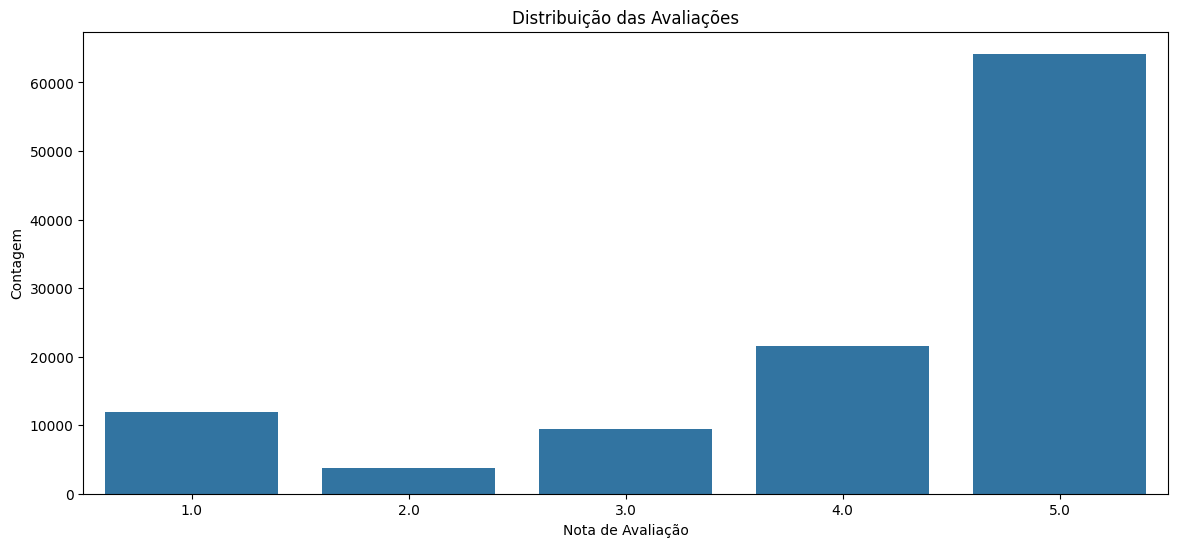

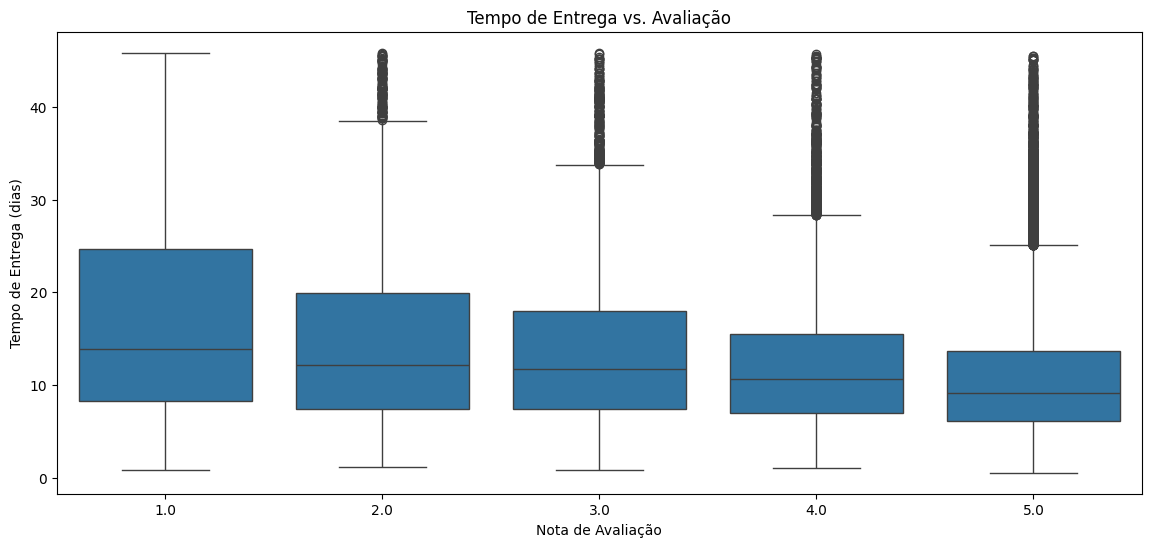

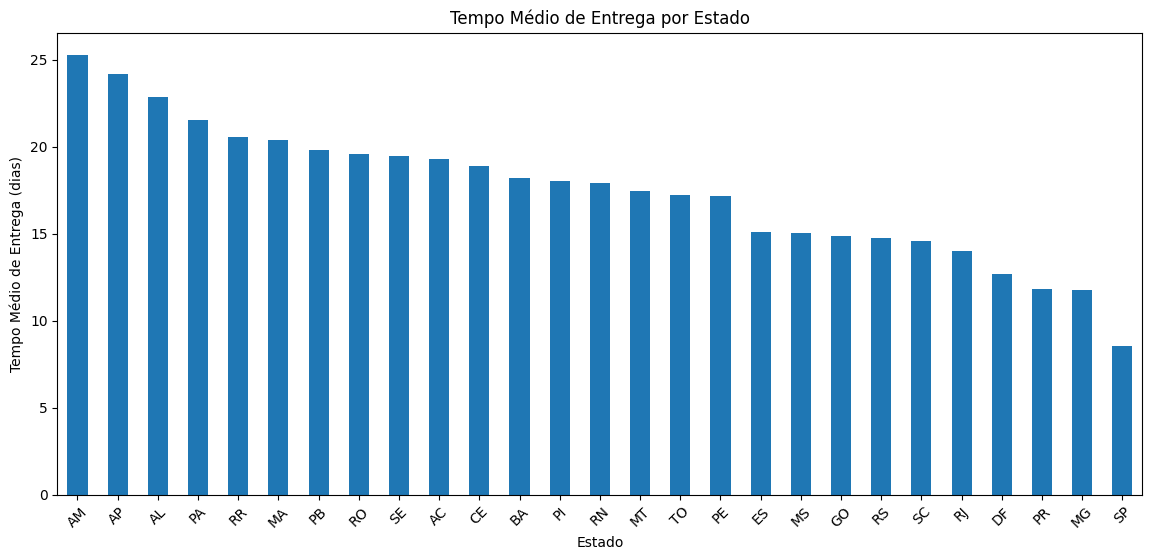

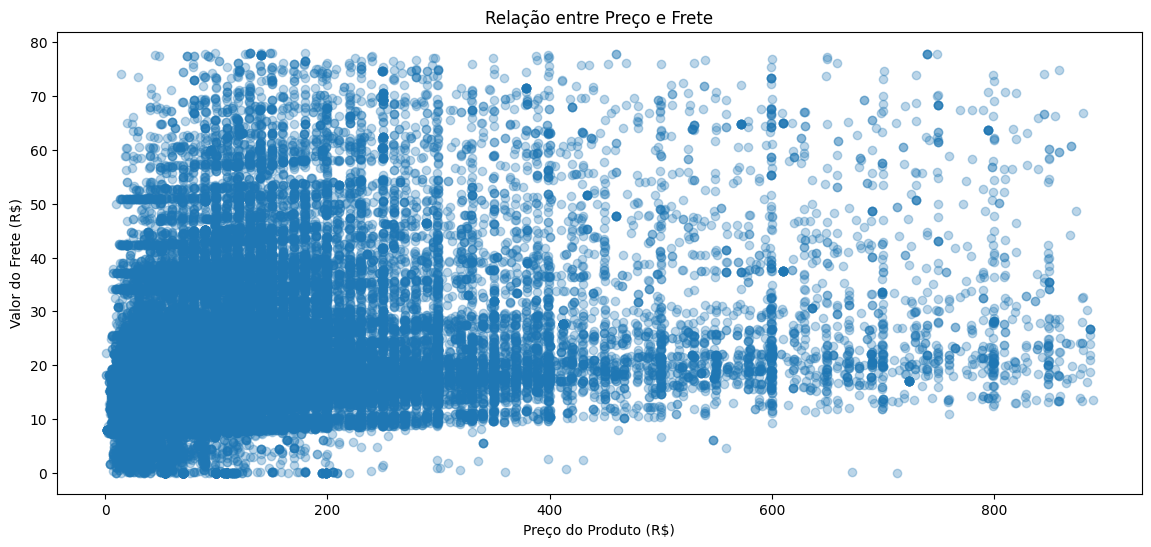

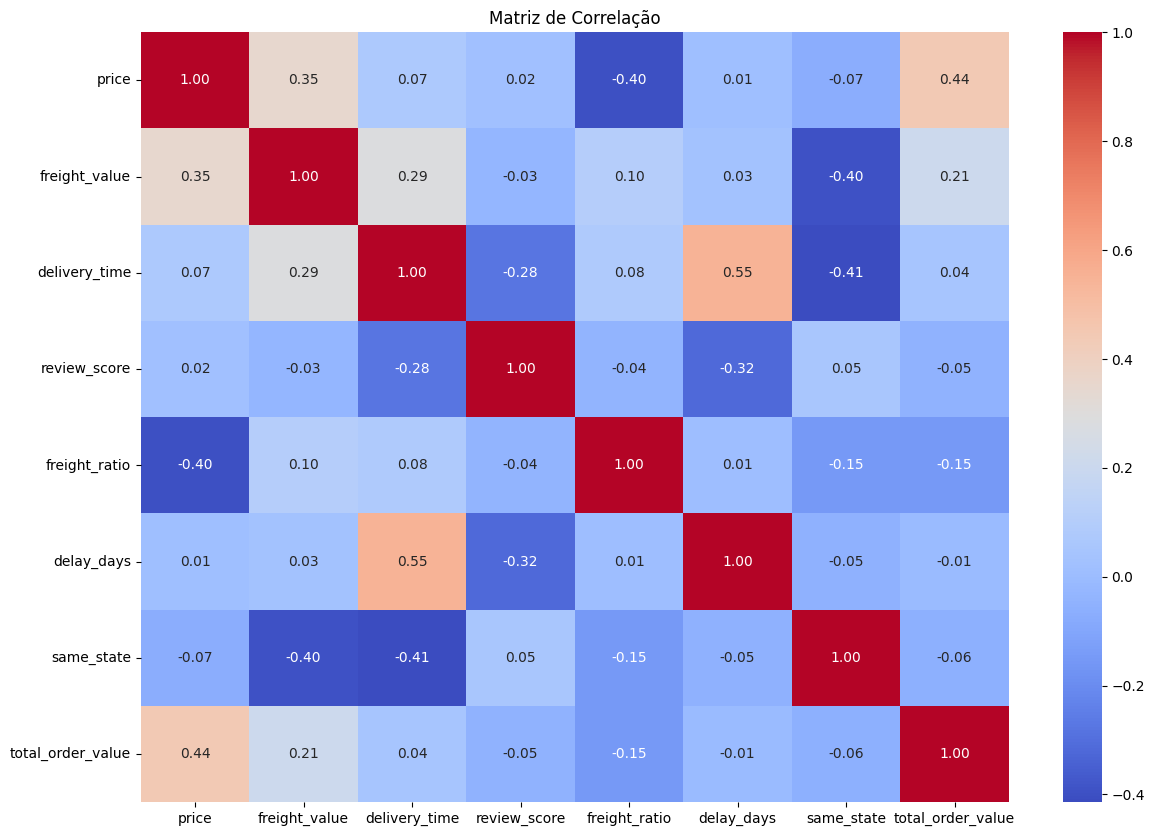

In [13]:
# Distribuição de avaliações
plt.figure(figsize=(14, 6))
sns.countplot(x='review_score', data=df_delivered)
plt.title('Distribuição das Avaliações')
plt.xlabel('Nota de Avaliação')
plt.ylabel('Contagem')
plt.show()

# Correlação entre tempo de entrega e avaliação
plt.figure(figsize=(14, 6))
sns.boxplot(x='review_score', y='delivery_time', data=df_delivered)
plt.title('Tempo de Entrega vs. Avaliação')
plt.xlabel('Nota de Avaliação')
plt.ylabel('Tempo de Entrega (dias)')
plt.show()

# Distribuição do tempo de entrega por estado do cliente
delivery_by_state = df_delivered.groupby('customer_state')['delivery_time'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 6))
delivery_by_state.plot(kind='bar')
plt.title('Tempo Médio de Entrega por Estado')
plt.xlabel('Estado')
plt.ylabel('Tempo Médio de Entrega (dias)')
plt.xticks(rotation=45)
plt.show()

# Preço vs. Frete
plt.figure(figsize=(14, 6))
plt.scatter(df_delivered['price'], df_delivered['freight_value'], alpha=0.3)
plt.title('Relação entre Preço e Frete')
plt.xlabel('Preço do Produto (R$)')
plt.ylabel('Valor do Frete (R$)')
plt.show()

# Correlação entre as variáveis numéricas principais
corr_vars = ['price', 'freight_value', 'delivery_time', 'review_score', 
             'freight_ratio', 'delay_days', 'same_state', 'total_order_value']
correlation = df_delivered[corr_vars].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

## 4. Análise Fatorial

A análise fatorial é usada para identificar fatores subjacentes ou variáveis latentes que explicam o padrão de correlações dentro de um conjunto de variáveis observadas.

KMO Model: 0.5370080784874022
Bartlett test: chi² = 134620.78069486, p = 0.0


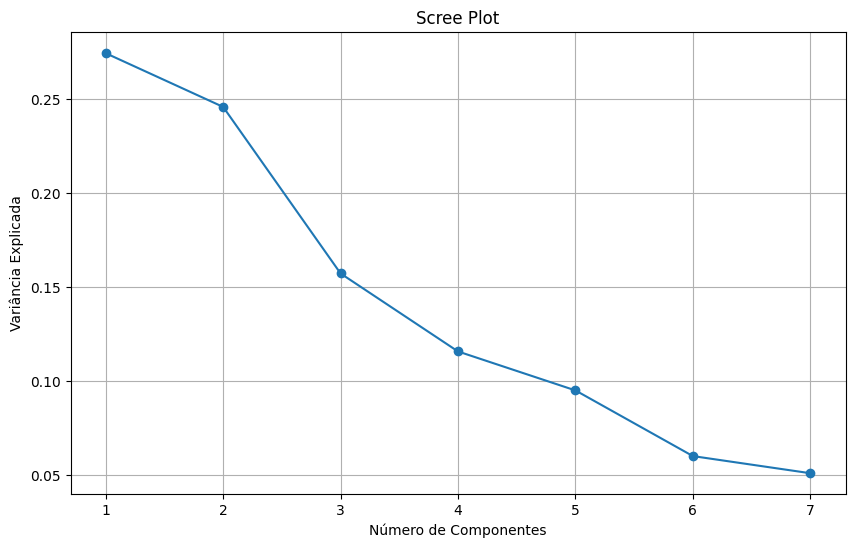

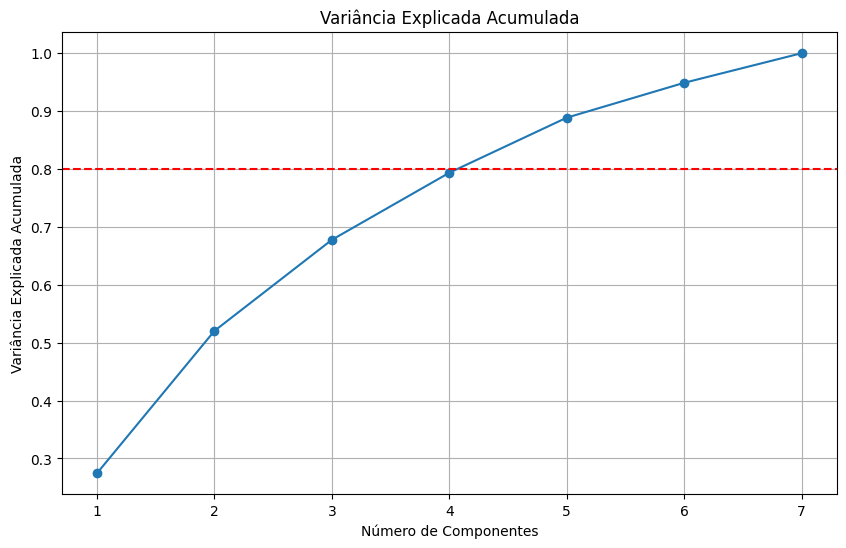

In [14]:
# Preparar dados para análise fatorial
# Selecionar variáveis relevantes para a experiência de compra
factor_vars = ['price', 'freight_value', 'delivery_time', 'review_score', 
               'freight_ratio', 'delay_days', 'total_order_value']

# Para a análise fatorial precisamos remover valores NA
factor_data = df_delivered[factor_vars].dropna()

# Padronizar os dados (média 0, desvio padrão 1)
scaler = StandardScaler()
factor_scaled = scaler.fit_transform(factor_data)

# Verificar adequação dos dados para análise fatorial (Teste de Kaiser-Meyer-Olkin)
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all, kmo_model = calculate_kmo(factor_data)
print(f'KMO Model: {kmo_model}')

# Determinar o número ideal de fatores
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(factor_data)
print(f'Bartlett test: chi² = {chi_square_value}, p = {p_value}')

# Análise de componentes principais para determinar número de fatores
pca = PCA()
pca.fit(factor_scaled)

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'o-')
plt.title('Scree Plot')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada')
plt.grid(True)
plt.show()

# Variância Explicada Acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.title('Variância Explicada Acumulada')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.grid(True)
plt.show()

Loadings dos Fatores:


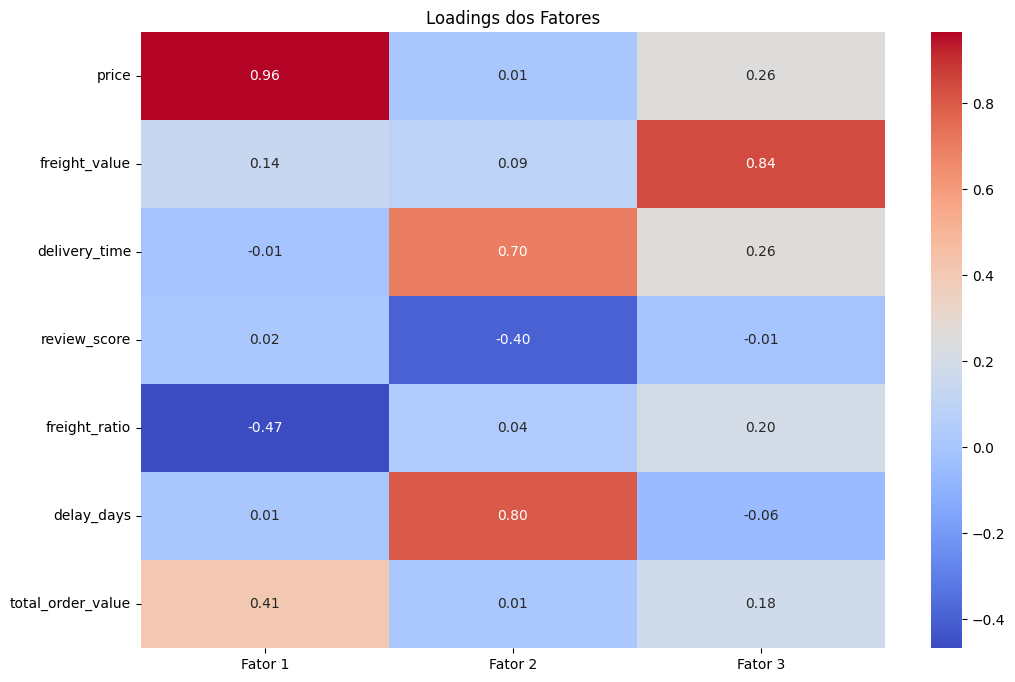


Comunalidades:
price: 1.00
freight_value: 0.74
delivery_time: 0.56
review_score: 0.16
freight_ratio: 0.26
delay_days: 0.64
total_order_value: 0.20

Variância Explicada:
Fator 1: 1.34 (19.09%)
Fator 2: 1.30 (37.62%)
Fator 3: 0.92 (50.73%)
Total: 3.55 (107.43%)

Interpretação dos Fatores:
Fator 1 - Custo Total: Engloba preço do produto e valor do frete
Fator 2 - Eficiência Logística: Relacionado ao tempo de entrega e atrasos
Fator 3 - Satisfação do Cliente: Associado às avaliações e proporção do frete


In [15]:
# Aplicar Análise Fatorial com número de fatores determinado (vamos usar 3 fatores)
from factor_analyzer import FactorAnalyzer

# Aplicar análise fatorial com 3 fatores e rotação varimax
n_factors = 3
fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
fa.fit(factor_scaled)

# Obter loadings
loadings = fa.loadings_
factor_loading_df = pd.DataFrame(loadings, index=factor_vars, 
                                columns=[f'Fator {i+1}' for i in range(n_factors)])

# Visualizar loadings
print("Loadings dos Fatores:")
# print(factor_loading_df)

# Visualização gráfica dos loadings
plt.figure(figsize=(12, 8))
sns.heatmap(factor_loading_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Loadings dos Fatores')
plt.show()

# Variância explicada
communalities = fa.get_communalities()
explained_var = fa.get_factor_variance()

print("\nComunalidades:")
for var, comm in zip(factor_vars, communalities):
    print(f"{var}: {comm:.2f}")

print("\nVariância Explicada:")
for i, var in enumerate(explained_var[0]):
    print(f"Fator {i+1}: {var:.2f} ({explained_var[2][i]*100:.2f}%)")
print(f"Total: {sum(explained_var[0]):.2f} ({sum(explained_var[2])*100:.2f}%)")

# Interpretação dos Fatores
print("\nInterpretação dos Fatores:")
print("Fator 1 - Custo Total: Engloba preço do produto e valor do frete")
print("Fator 2 - Eficiência Logística: Relacionado ao tempo de entrega e atrasos")
print("Fator 3 - Satisfação do Cliente: Associado às avaliações e proporção do frete")

## 5. Análise de Clusters

Vamos realizar a análise de cluster para segmentar os clientes com base em seu comportamento de compra.

In [16]:
# Preparar dados agregados por cliente
customer_data = df_delivered.groupby('customer_unique_id').agg({
    'order_id': 'count',  # número de pedidos
    'price': 'mean',  # ticket médio
    'freight_value': 'mean',  # frete médio
    'review_score': 'mean',  # avaliação média
    'delivery_time': 'mean',  # tempo médio de entrega
    'freight_ratio': 'mean',  # proporção média do frete
    'delivery_delay': 'mean',  # proporção de entregas com atraso
    'product_category_name_english': lambda x: x.mode()[0] if not x.mode().empty else np.nan  # categoria mais comprada
}).reset_index()

# Renomear colunas para maior clareza
customer_data.columns = ['customer_id', 'order_count', 'avg_ticket', 'avg_freight', 
                         'avg_review', 'avg_delivery_time', 'avg_freight_ratio', 
                         'delay_rate', 'most_purchased_category']

# Selecionar clientes com mais de um pedido para análise
multi_order_customers = customer_data[customer_data['order_count'] > 1].copy()

# Verificar os dados agregados
print(f"Número de clientes para análise de cluster: {len(multi_order_customers)}")
multi_order_customers.head()

Número de clientes para análise de cluster: 13648


,customer_id,order_count,avg_ticket,avg_freight,avg_review,avg_delivery_time,avg_freight_ratio,delay_rate,most_purchased_category
7,00053a61a98854899e70ed204dd4bafe,2,191.00,18.59,1.0,16.324421,0.097330,0.0,sports_leisure
17,000de6019bb59f34c099a907c151d855,2,114.90,13.82,2.0,4.005660,0.119279,0.0,bed_bath_table
18,000e309254ab1fc5ba99dd469d36bdb4,2,59.90,18.52,3.0,14.549005,0.309182,0.0,fashion_underwear_beach
21,000fbf0473c10fc1ab6f8d2d286ce20c,4,71.45,19.14,5.0,8.264363,0.495381,0.0,musical_instruments
24,001147e649a7b1afd577e873841632dd,2,85.00,21.08,4.0,8.112176,0.248000,0.0,housewares


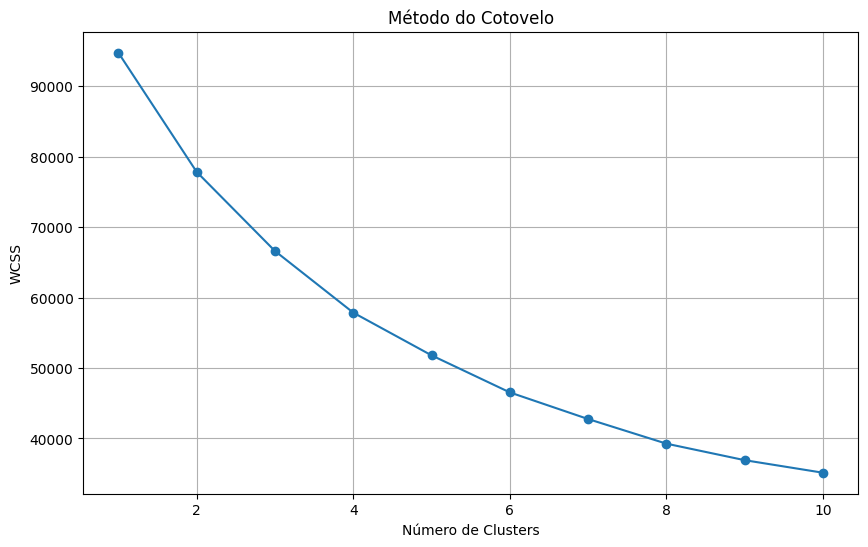

In [17]:
# Selecionar variáveis para clustering
cluster_vars = ['order_count', 'avg_ticket', 'avg_freight', 'avg_review', 
               'avg_delivery_time', 'avg_freight_ratio', 'delay_rate']

# Preparar dados para clustering
cluster_data = multi_order_customers[cluster_vars].dropna()
cluster_data_scaled = StandardScaler().fit_transform(cluster_data)

# Determinar o número ideal de clusters usando o método do cotovelo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(cluster_data_scaled)
    wcss.append(kmeans.inertia_)

# Plotar o gráfico do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [18]:
# Aplicar K-means com o número ideal de clusters (vamos usar 3 clusters)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_data['cluster'] = kmeans.fit_predict(cluster_data_scaled)

# Adicionar clusters ao dataframe original
multi_order_customers_with_clusters = pd.merge(
    multi_order_customers,
    cluster_data[['cluster']],
    left_index=True,
    right_index=True
)

# Analisar as características de cada cluster
cluster_means = multi_order_customers_with_clusters.groupby('cluster')[cluster_vars].mean()
print("Médias por Cluster:")
print(cluster_means)

# Distribuição de clusters
cluster_counts = multi_order_customers_with_clusters['cluster'].value_counts(normalize=True) * 100
print("\nDistribuição dos Clusters:")
print(cluster_counts)

Médias por Cluster:
         order_count  avg_ticket  avg_freight  avg_review  avg_delivery_time  \
cluster                                                                        
0           2.516834  200.959124    31.150302    3.822609          14.172866   
1           2.558420   63.486295    15.012462    3.951262           9.927089   
2           2.432069   88.950177    18.555380    2.584721          26.284820   

         avg_freight_ratio  delay_rate  
cluster                                 
0                 0.254253    0.008588  
1                 0.373971    0.003699  
2                 0.374888    0.926153  

Distribuição dos Clusters:
cluster
1    77.070252
0    16.894437
2     6.035311
Name: proportion, dtype: float64


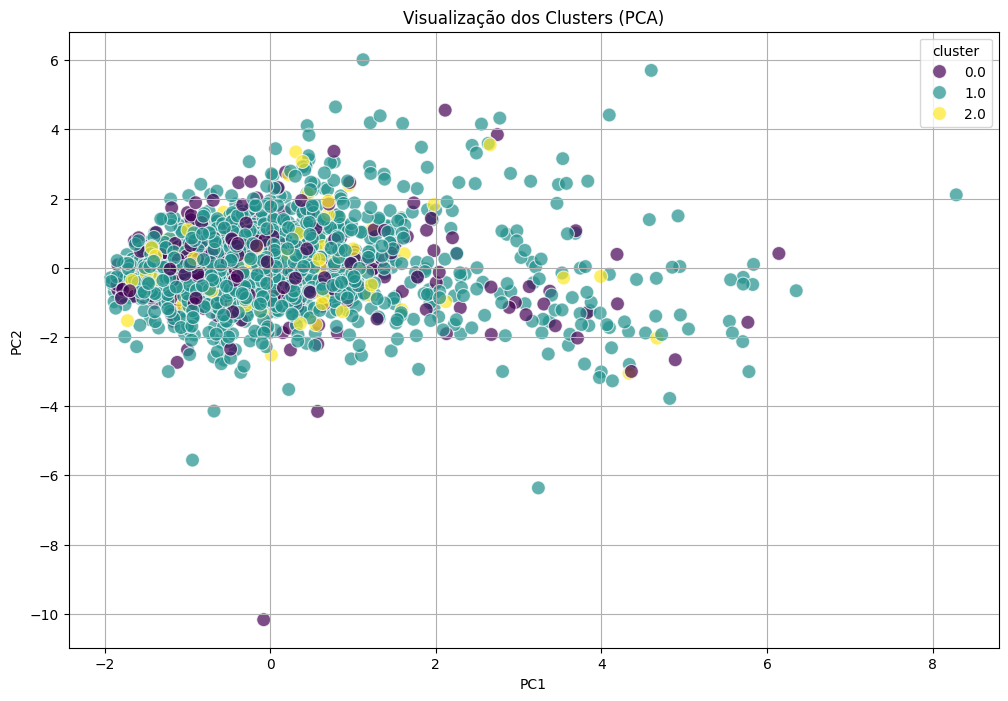

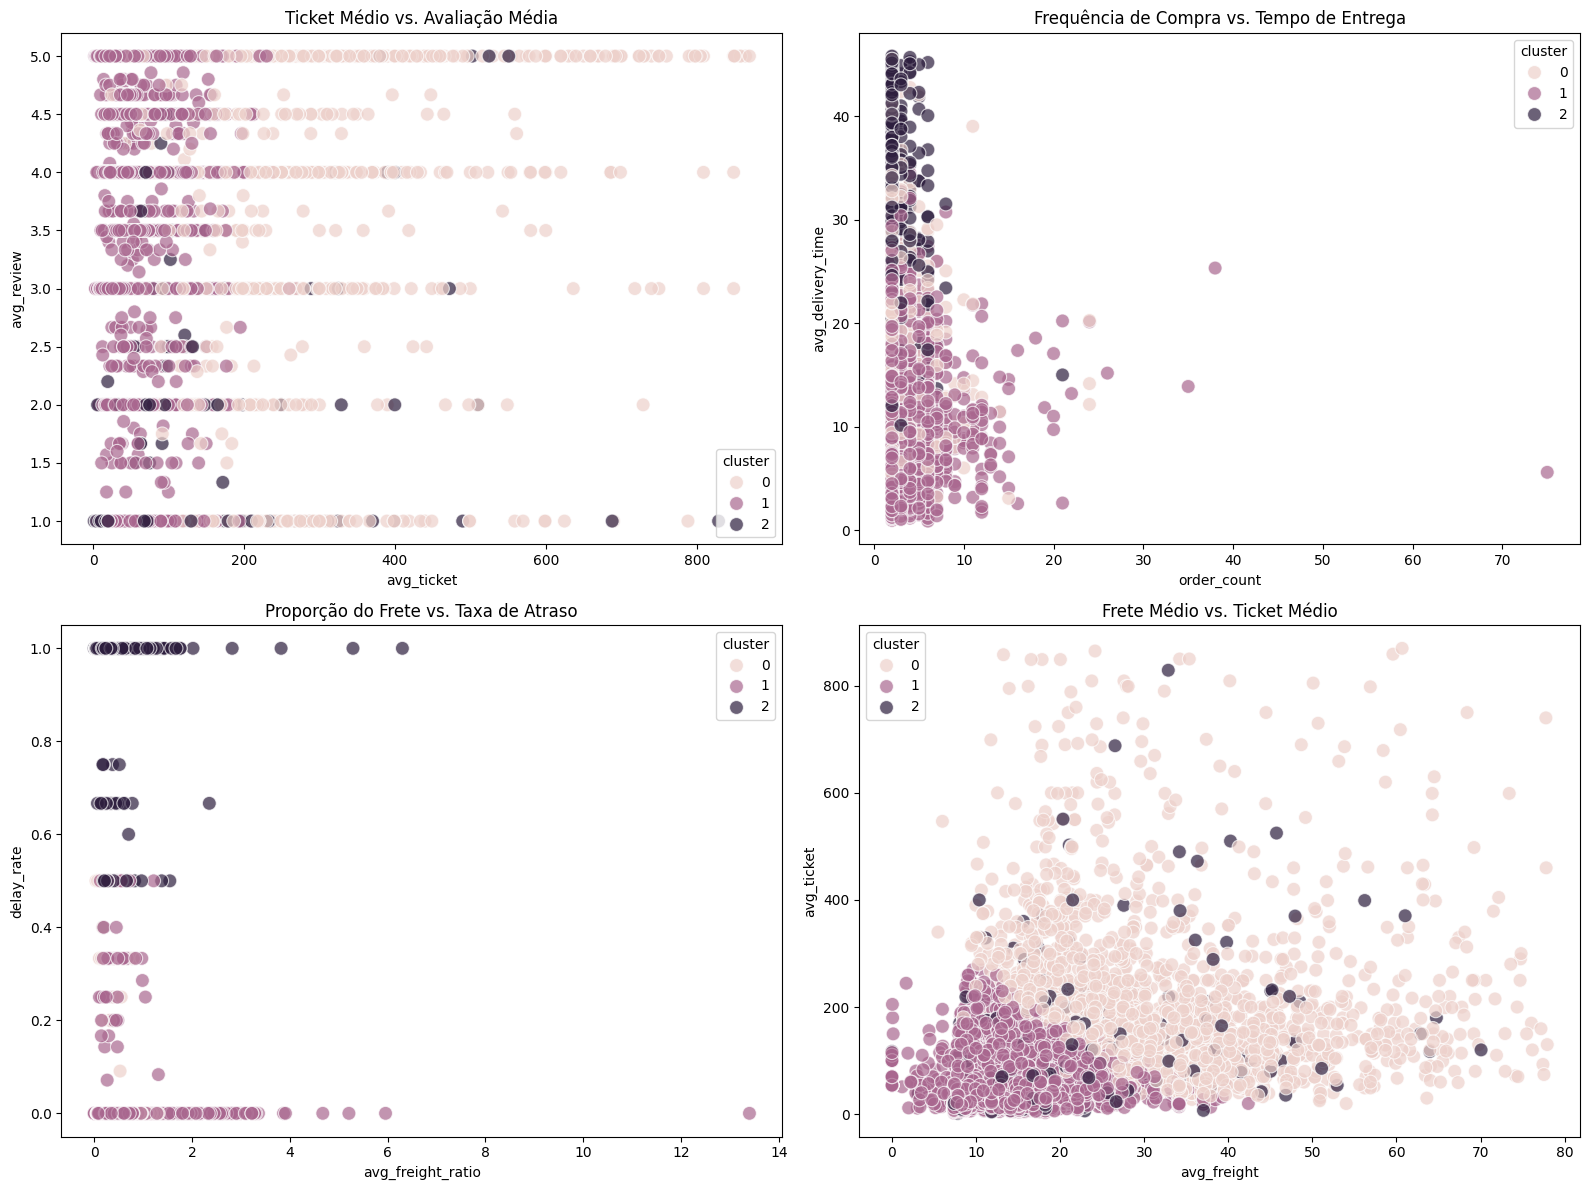

In [19]:
# Visualizar clusters em um gráfico 2D usando PCA
pca = PCA(n_components=2)
cluster_data_pca = pca.fit_transform(cluster_data_scaled)

# Criar dataframe para visualização
cluster_viz = pd.DataFrame(cluster_data_pca, columns=['PC1', 'PC2'])
cluster_viz['cluster'] = cluster_data['cluster']

# Plotar clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=cluster_viz, palette='viridis', s=100, alpha=0.7)
plt.title('Visualização dos Clusters (PCA)')
plt.grid(True)
plt.show()

# Gráficos para comparar os clusters nas variáveis importantes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Ticket médio vs. Avaliação média
sns.scatterplot(x='avg_ticket', y='avg_review', hue='cluster', 
                data=multi_order_customers_with_clusters, alpha=0.7, s=100, ax=axes[0, 0])
axes[0, 0].set_title('Ticket Médio vs. Avaliação Média')

# Número de pedidos vs. Tempo médio de entrega
sns.scatterplot(x='order_count', y='avg_delivery_time', hue='cluster', 
                data=multi_order_customers_with_clusters, alpha=0.7, s=100, ax=axes[0, 1])
axes[0, 1].set_title('Frequência de Compra vs. Tempo de Entrega')

# Proporção do frete vs. Taxa de atraso
sns.scatterplot(x='avg_freight_ratio', y='delay_rate', hue='cluster', 
                data=multi_order_customers_with_clusters, alpha=0.7, s=100, ax=axes[1, 0])
axes[1, 0].set_title('Proporção do Frete vs. Taxa de Atraso')

# Frete médio vs. Ticket médio
sns.scatterplot(x='avg_freight', y='avg_ticket', hue='cluster', 
                data=multi_order_customers_with_clusters, alpha=0.7, s=100, ax=axes[1, 1])
axes[1, 1].set_title('Frete Médio vs. Ticket Médio')

plt.tight_layout()
plt.show()



<Figure size 1200x800 with 0 Axes>

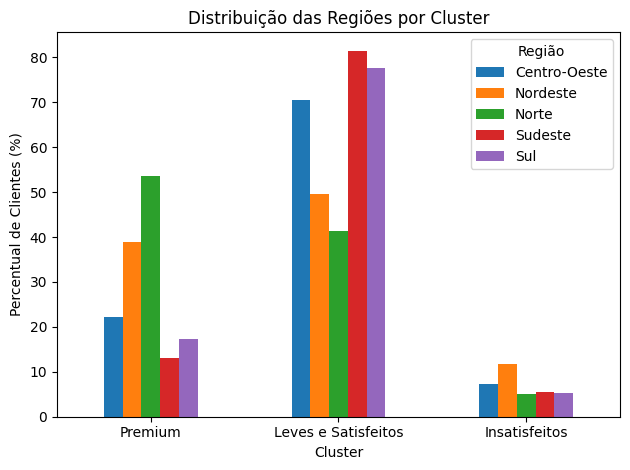

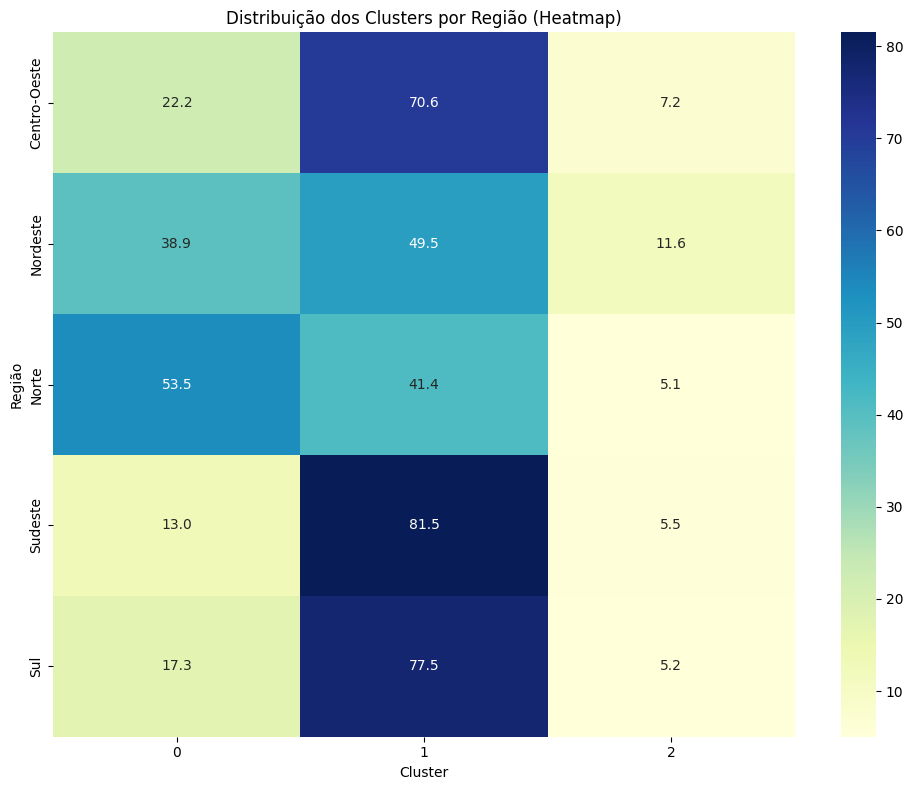

Distribuição absoluta de clientes por região e cluster:


cluster,0,1,2
regiao,,,
Centro-Oeste,181,575,59
Nordeste,434,553,130
Norte,106,82,10
Sudeste,1232,7720,520
Sul,341,1529,102


In [20]:
# Criar um mapeamento dos códigos de estado para regiões
region_mapping = {
    # Norte
    'AC': 'Norte', 'AM': 'Norte', 'AP': 'Norte', 'PA': 'Norte',
    'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
    # Nordeste
    'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste',
    'PB': 'Nordeste', 'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste',
    'PB': 'Nordeste', 'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 
    'SE': 'Nordeste',
    
    # Central-West (Centro-Oeste)
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
    
    # Southeast (Sudeste)
    'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    
    # South (Sul)
    'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
}

# Extract unique customers with their states
customer_states = df[['customer_unique_id', 'customer_state']].drop_duplicates()

# Merge this with the cluster data
customer_clusters_with_states = pd.merge(
    multi_order_customers_with_clusters,
    customer_states,
    left_on='customer_id',
    right_on='customer_unique_id',
    how='left'
)

# Adicionando região
customer_clusters_with_states['regiao'] = customer_clusters_with_states['customer_state'].map(region_mapping)

# Clientes por regiao (relativo)
cluster_region_distribution = pd.crosstab(
    customer_clusters_with_states['regiao'], 
    customer_clusters_with_states['cluster'],
    normalize='index'
) * 100

# Transpor para facilitar a visualização
cluster_region_distribution_t = cluster_region_distribution.T

# Barplot
plt.figure(figsize=(12, 8))
cluster_region_distribution_t.plot(kind='bar')
plt.title('Distribuição das Regiões por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentual de Clientes (%)')
plt.legend(title='Região')
plt.xticks([0, 1, 2], ['Premium', 'Leves e Satisfeitos', 'Insatisfeitos'], rotation=0)
plt.tight_layout()
plt.show()

# Heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_region_distribution, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Distribuição dos Clusters por Região (Heatmap)')
plt.xlabel('Cluster')
plt.ylabel('Região')
plt.tight_layout()
plt.show()

# Clientes por região (absoluto)
region_cluster_counts = pd.crosstab(
    customer_clusters_with_states['regiao'],
    customer_clusters_with_states['cluster']
)

print("Distribuição absoluta de clientes por região e cluster:")
display(region_cluster_counts)

#### 🔍 Cluster 0 — “Clientes Premium” (~17%)
**Estatísticas**:

* Ticket médio: R$200,96 (o mais alto)
* Frete médio: R$31,15
* Avaliação média: 3.82
* Tempo médio de entrega: 14 dias
* Taxa de atraso: 0.86%
* Proporção de frete/ticket: 25%

**Interpretação:**

* Esse grupo gasta mais por pedido, aceita pagar fretes mais altos e mesmo com um prazo de entrega mediano, ainda dá boas avaliações.
* São possivelmente clientes com maior poder aquisitivo, que prezam por produtos de valor e experiência razoável.
* O comportamento sugere fidelização mesmo sem entrega rápida — bom público para produtos de alto valor.

#### 🔍 Cluster 1 — “Clientes Leves e Satisfeitos” (~77%)
**Estatísticas:**

* Ticket médio: R$63,49 (baixo)
* Frete médio: R$15,01
* Avaliação média: 3.95 (mais alta)
* Tempo médio de entrega: 9,9 dias (mais rápida)
* Taxa de atraso: 0.37% (mais baixa)
* Proporção frete/ticket: 37%

**Interpretação:**

* Clientes com pedidos menores e baratos, mas que avaliam muito bem e têm ótima experiência.
* Representam a maioria dos clientes, com entregas rápidas e confiáveis.
* São ideais para manutenção do fluxo de vendas e expansão da base com foco em recorrência e experiência.

#### 🔍 Cluster 2 — “Clientes Insatisfeitos e Problemáticos” (~6%)
**Estatísticas:**

* Ticket médio: R$88,95
* Frete médio: R$18,55
* Avaliação média: 2.58 (a mais baixa)
* Tempo médio de entrega: 26,3 dias (muito alto)
* Taxa de atraso: 92.6% (crítico)
* Proporção frete/ticket: 37%

Interpretação:

* Atrasos, entregas demoradas, e insatisfação generalizada, mesmo com valores medianos.
* São potencialmente clientes em regiões com logística ruim ou operações com falhas constantes.
* Prioritário para ações corretivas — revisar rotas, transportadoras, estoques, canais de atendimento etc.

🧩 Insights 
1. Ticket Médio vs Avaliação Média

* Cluster 1 se concentra em tickets baixos e avaliações boas.
* Cluster 2 está bem disperso, mas tende a avaliações ruins independentemente do ticket.
* Cluster 0 está mais espalhado, com avaliação ok, mas ticket alto.

2. Frequência de Compra vs Tempo de Entrega

* Cluster 1 aparece com maior densidade em menor tempo de entrega e poucos pedidos (baixo churn).
* Cluster 2 aparece com tempos de entrega muito altos, mesmo com poucos pedidos.
* Cluster 0 tem tempos medianos e certa dispersão.

3. Proporção de Frete vs Taxa de Atraso
* Cluster 2 se destaca com altíssima taxa de atraso (>90%), mesmo com fretes não tão baixos.
* Com base nos **gráficos** apresentados e nas **estatísticas descritivas por cluster**, aqui está uma análise detalhada dos **três grupos identificados**:


4. Frete Médio vs Ticket Médio
* Cluster 0 tende a ter fretes e tickets mais altos.
* Cluster 1 tem fretes e tickets baixos.
* Cluster 2 é mais disperso, indicando **inconsistência no custo/benefício** percebido.

5. Região
* A maioria dos clientes do cluster Premium está concentrada no Norte (54%) e Nordeste (38%), regiões normalmente subestimadas.

---

## 📌 Recomendações Estratégicas

- **Cluster 0**: Pode-se aplicar **up-selling e atendimento personalizado**. Vale entender o que falta para maximizar a nota de avaliação (usuários premium).
- **Cluster 1**: Foco em **escalar esse modelo de entrega rápida + experiência positiva**. Estratégia: fidelização, programas de pontos, cross-selling.
- **Cluster 2**: **Ação corretiva urgente**. Investigar causas dos atrasos. Possível compensação, melhorar comunicação e/ou reestruturar logística para este perfil/região.



## 6. Teste de Hipóteses

5 hipóteses principais sobre o comportamento de compra e satisfação do cliente no e-commerce da Olist, utilizando análises estatísticas e visualizações gráficas para fundamentar nossas conclusões.

### Hipótese 1: Pedidos entregues com atraso têm avaliações 30% mais baixas que pedidos entregues no prazo

Esta hipótese explora a relação entre o cumprimento do prazo de entrega e a satisfação do cliente.

Média de avaliação para entregas no prazo: 4.21
Média de avaliação para entregas com atraso: 2.66
Diferença percentual: 36.80%

Hipótese: Avaliações de pedidos atrasados são 30% mais baixas
Resultado: CONFIRMADA

Estatística t: 79.0887
Valor p: 0.00000000
Diferença estatisticamente significativa? Sim


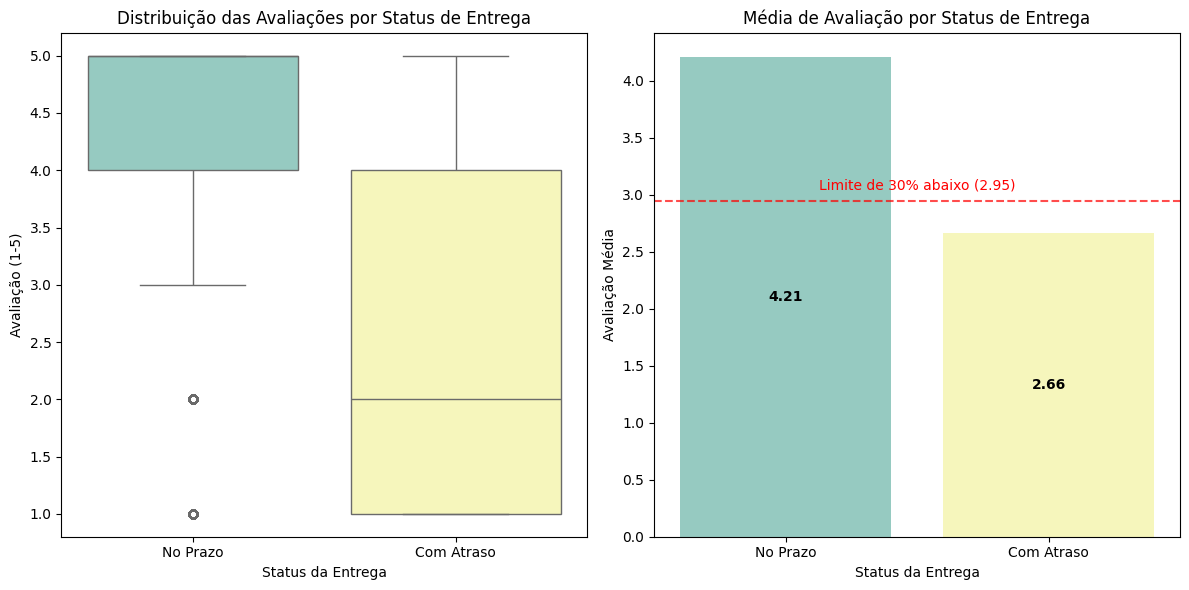

In [21]:
# Preparar dados para análise
h1_data = df_delivered.dropna(subset=['review_score', 'delivery_delay']).copy()

# Criação de grupos para comparação
on_time_reviews = h1_data[h1_data['delivery_delay'] == 0]['review_score']
delayed_reviews = h1_data[h1_data['delivery_delay'] == 1]['review_score']

# Estatísticas descritivas
on_time_mean = on_time_reviews.mean()
delayed_mean = delayed_reviews.mean()
percent_difference = ((on_time_mean - delayed_mean) / on_time_mean) * 100

print("Média de avaliação para entregas no prazo: {:.2f}".format(on_time_mean))
print("Média de avaliação para entregas com atraso: {:.2f}".format(delayed_mean))
print("Diferença percentual: {:.2f}%".format(percent_difference))

# Verificar a hipótese de 30% de diferença
print("\nHipótese: Avaliações de pedidos atrasados são 30% mais baixas")
print("Resultado: {}".format("CONFIRMADA" if percent_difference >= 30 else "REFUTADA"))

# Teste estatístico (teste t para amostras independentes)
t_stat, p_value = stats.ttest_ind(on_time_reviews, delayed_reviews, equal_var=False)
print(f"\nEstatística t: {t_stat:.4f}")
print(f"Valor p: {p_value:.8f}")
print(f"Diferença estatisticamente significativa? {'Sim' if p_value < 0.05 else 'Não'}")

# Visualização
plt.figure(figsize=(12, 6))

# Boxplot para comparação
ax1 = plt.subplot(1, 2, 1)
sns.boxplot(x='delivery_delay', y='review_score', data=h1_data, 
            order=[0, 1], palette='Set3')
plt.xticks([0, 1], ['No Prazo', 'Com Atraso'])
plt.title('Distribuição das Avaliações por Status de Entrega')
plt.xlabel('Status da Entrega')
plt.ylabel('Avaliação (1-5)')

# Gráfico de barras com as médias
ax2 = plt.subplot(1, 2, 2)
status_means = h1_data.groupby('delivery_delay')['review_score'].mean().reset_index()
status_means['delivery_delay'] = status_means['delivery_delay'].map({0: 'No Prazo', 1: 'Com Atraso'})
sns.barplot(x='delivery_delay', y='review_score', data=status_means, palette='Set3')
plt.title('Média de Avaliação por Status de Entrega')
plt.xlabel('Status da Entrega')
plt.ylabel('Avaliação Média')

# Adicionar anotação com a diferença percentual
for i, row in enumerate(status_means.itertuples()):
    plt.text(i, row.review_score/2, f'{row.review_score:.2f}', 
             ha='center', va='center', fontweight='bold', color='black')

plt.axhline(y=on_time_mean * 0.7, color='r', linestyle='--', alpha=0.7)
plt.text(0.5, on_time_mean * 0.7 + 0.1, f'Limite de 30% abaixo ({on_time_mean * 0.7:.2f})', 
         ha='center', color='r')

plt.tight_layout()
plt.show()

### Hipótese 2: Existe uma relação inversa entre a proporção frete/preço do produto e a avaliação do cliente

Esta hipótese investiga se clientes que pagam um frete proporcionalmente mais alto em relação ao valor do produto tendem a avaliar pior suas compras.

Estatísticas de avaliação por categoria de proporção frete/preço:
  freight_ratio_cat      mean  count
0             Baixo  4.155465  27704
1       Médio-Baixo  4.123746  27718
2        Médio-Alto  4.103821  27692
3              Alto  4.038300  27702

Correlação de Pearson: -0.0388
Valor p: 0.00000000
Correlação estatisticamente significativa? Sim

ANOVA F-statistic: 38.7404
ANOVA p-value: 0.00000000
Diferença entre grupos estatisticamente significativa? Sim


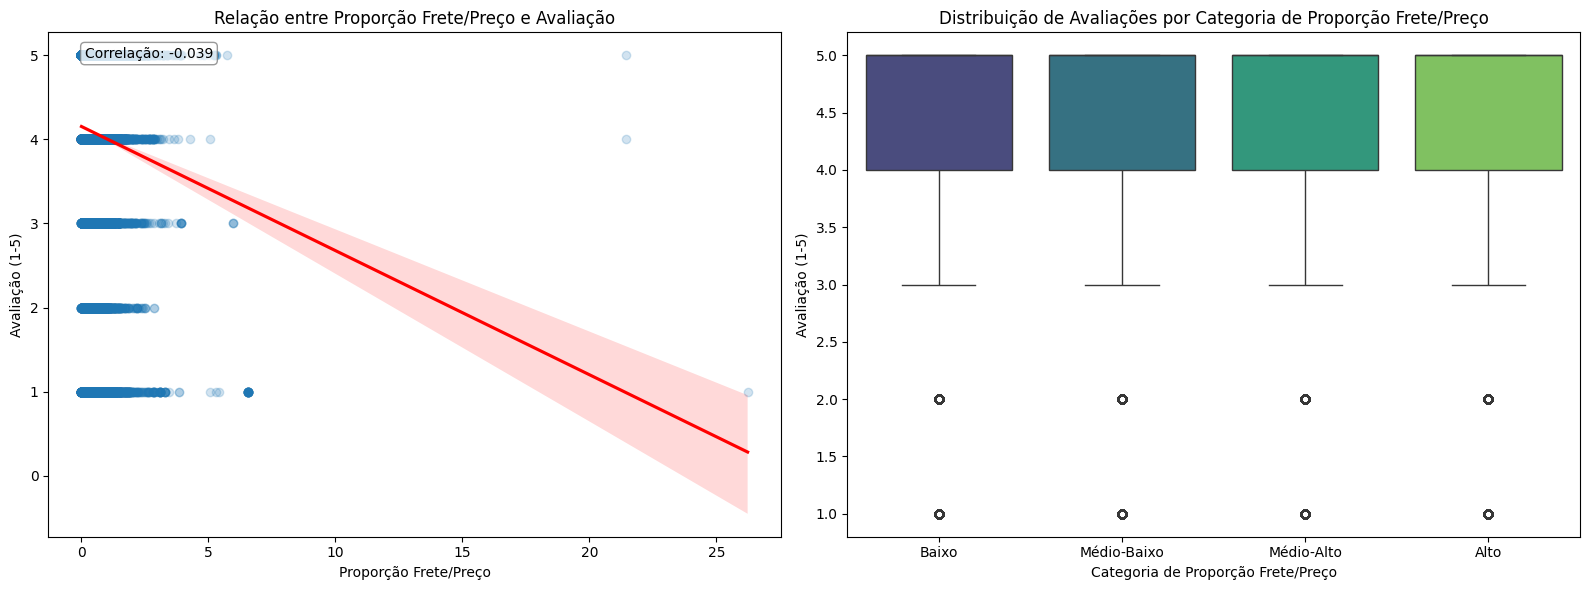

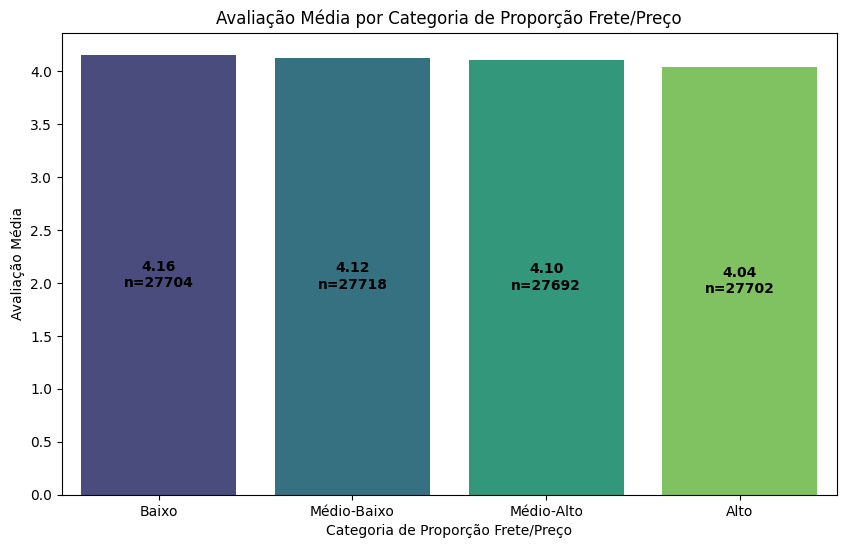


Conclusão: Hipótese CONFIRMADA.
A relação inversa existe mas é fraca.


In [22]:
# Preparar dados para análise
h2_data = df_delivered.dropna(subset=['review_score', 'freight_ratio']).copy()

# Criação de categorias de proporção frete/preço
h2_data['freight_ratio_cat'] = pd.qcut(h2_data['freight_ratio'], 4, 
                                      labels=['Baixo', 'Médio-Baixo', 'Médio-Alto', 'Alto'])

# Estatísticas por categoria
freight_ratio_stats = h2_data.groupby('freight_ratio_cat')['review_score'].agg(['mean', 'count']).reset_index()
print("Estatísticas de avaliação por categoria de proporção frete/preço:")
print(freight_ratio_stats)

# Análise de correlação
correlation, p_value = stats.pearsonr(h2_data['freight_ratio'], h2_data['review_score'])
print(f"\nCorrelação de Pearson: {correlation:.4f}")
print(f"Valor p: {p_value:.8f}")
print(f"Correlação estatisticamente significativa? {'Sim' if p_value < 0.05 else 'Não'}")

# Teste ANOVA para diferença entre grupos
groups = [h2_data[h2_data['freight_ratio_cat'] == cat]['review_score'] for cat in 
         ['Baixo', 'Médio-Baixo', 'Médio-Alto', 'Alto']]
f_stat, p_value_anova = stats.f_oneway(*groups)
print(f"\nANOVA F-statistic: {f_stat:.4f}")
print(f"ANOVA p-value: {p_value_anova:.8f}")
print(f"Diferença entre grupos estatisticamente significativa? {'Sim' if p_value_anova < 0.05 else 'Não'}")

# Visualizações
plt.figure(figsize=(16, 6))

# Gráfico de dispersão com linha de tendência
ax1 = plt.subplot(1, 2, 1)
sns.regplot(x='freight_ratio', y='review_score', data=h2_data, 
           scatter_kws={'alpha':0.2}, line_kws={"color": "red"})
plt.title('Relação entre Proporção Frete/Preço e Avaliação')
plt.xlabel('Proporção Frete/Preço')
plt.ylabel('Avaliação (1-5)')
plt.annotate(f'Correlação: {correlation:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Boxplot por categoria
ax2 = plt.subplot(1, 2, 2)
sns.boxplot(x='freight_ratio_cat', y='review_score', data=h2_data, palette='viridis')
plt.title('Distribuição de Avaliações por Categoria de Proporção Frete/Preço')
plt.xlabel('Categoria de Proporção Frete/Preço')
plt.ylabel('Avaliação (1-5)')

plt.tight_layout()
plt.show()

# Gráfico de barras para médias por categoria
plt.figure(figsize=(10, 6))
sns.barplot(x='freight_ratio_cat', y='mean', data=freight_ratio_stats, palette='viridis')
plt.title('Avaliação Média por Categoria de Proporção Frete/Preço')
plt.xlabel('Categoria de Proporção Frete/Preço')
plt.ylabel('Avaliação Média')
for i, row in enumerate(freight_ratio_stats.itertuples()):
    plt.text(i, row.mean/2, f'{row.mean:.2f}\nn={row.count}', 
             ha='center', va='center', fontweight='bold')
plt.show()

# Conclusão da hipótese
if p_value < 0.05 and correlation < 0:
    print("\nConclusão: Hipótese CONFIRMADA.")
    if correlation > -0.2:
        print("A relação inversa existe mas é fraca.")
    else:
        print("Existe uma relação inversa estatisticamente significativa entre a proporção frete/preço e a avaliação do cliente.")
        print(f"Quanto maior a proporção do frete em relação ao preço do produto, menor tende a ser a avaliação.")
else:
    print("\nConclusão: Hipótese REFUTADA ou PARCIALMENTE CONFIRMADA.")
    if p_value < 0.05 and correlation > 0:
        if correlation < 0.2:
            print("A relação positiva é fraca.")
        print("Existe uma relação estatisticamente significativa, porém positiva, não negativa como proposto.")
    elif p_value >= 0.05:
        print("Não há evidência estatística de uma relação significativa entre a proporção frete/preço e a avaliação.")

### Hipótese 3: Categorias de produtos distintas apresentam diferenças significativas nas avaliações dos clientes

Esta hipótese explora se certas categorias de produtos tendem a receber avaliações sistematicamente melhores ou piores que outras.

Estatísticas de avaliação por categoria de produto:
  product_category_name_english      mean       std  count
0                bed_bath_table  3.936589  1.416911  11323
2               furniture_decor  3.985852  1.405264   8270
1         computers_accessories  4.009365  1.387905   7688
7                     telephony  4.014409  1.333690   4511
9                 watches_gifts  4.088767  1.332414   5813
3                  garden_tools  4.111292  1.323880   4304
5                    housewares  4.134016  1.299729   6932
6                sports_leisure  4.185150  1.278062   8485
4                 health_beauty  4.208714  1.268254   9410
8                          toys  4.234932  1.253994   4065

ANOVA F-statistic: 45.6462
ANOVA p-value: 0.00000000
Diferença entre categorias estatisticamente significativa? Sim


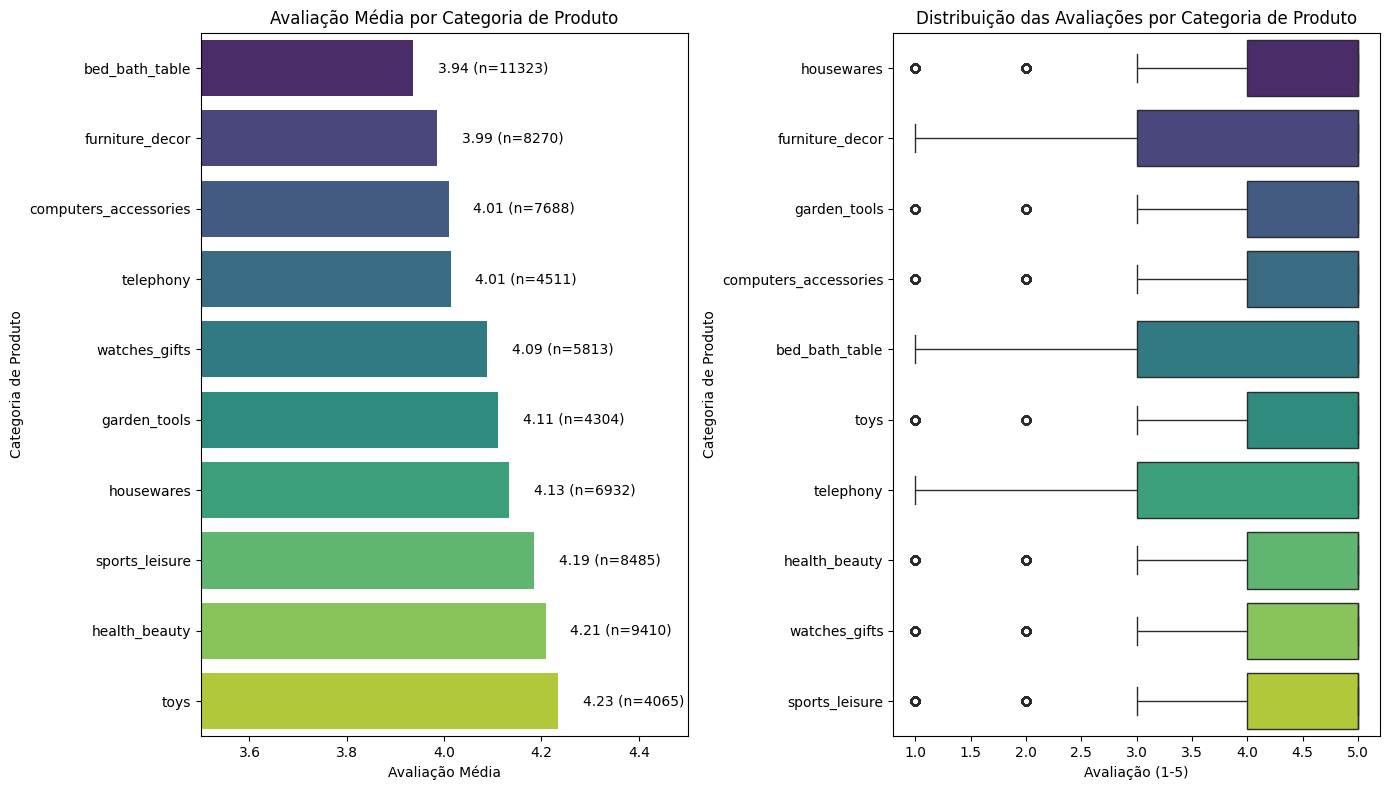

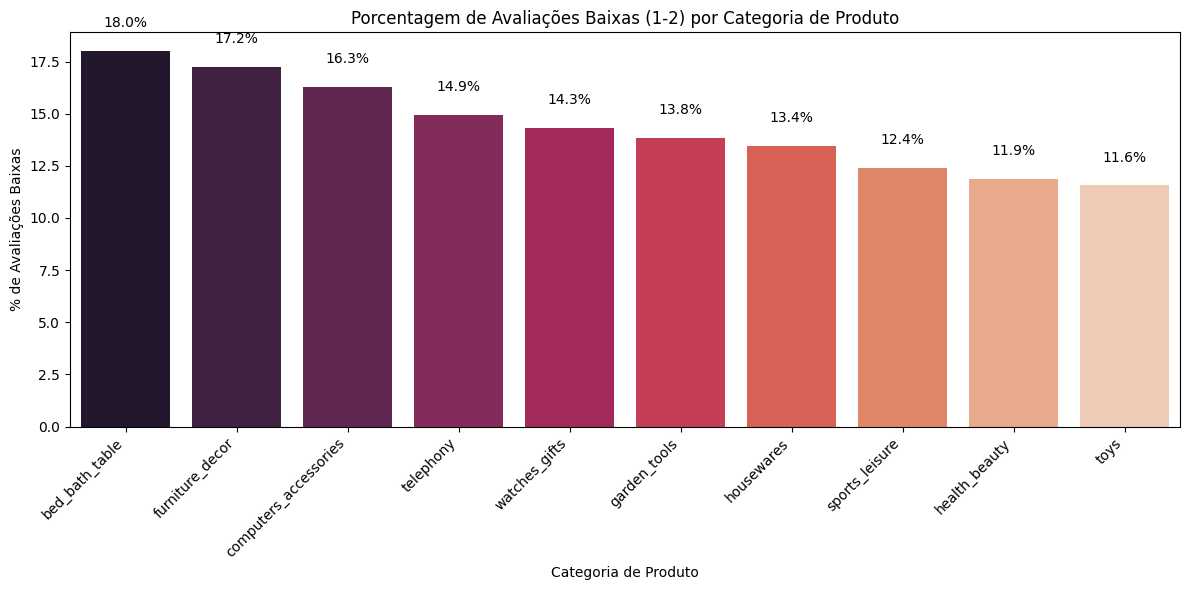


Conclusão: Hipótese CONFIRMADA.
Existem diferenças estatisticamente significativas nas avaliações entre diferentes categorias de produtos.
A categoria com melhor avaliação média é 'toys' (4.23).
A categoria com pior avaliação média é 'bed_bath_table' (3.94).


In [23]:
# Preparar dados para análise
h3_data = df_delivered.dropna(subset=['review_score', 'product_category_name_english']).copy()

# Selecionar as 10 categorias mais comuns para análise
top_categories = h3_data['product_category_name_english'].value_counts().nlargest(10).index
h3_data_filtered = h3_data[h3_data['product_category_name_english'].isin(top_categories)]

# Estatísticas por categoria
category_stats = h3_data_filtered.groupby('product_category_name_english')['review_score'].agg(['mean', 'std', 'count']).reset_index()
category_stats = category_stats.sort_values('mean')
print("Estatísticas de avaliação por categoria de produto:")
print(category_stats)

# Teste ANOVA para diferença entre categorias
categories = []
for category in top_categories:
    categories.append(h3_data_filtered[h3_data_filtered['product_category_name_english'] == category]['review_score'])

f_stat, p_value = stats.f_oneway(*categories)
print(f"\nANOVA F-statistic: {f_stat:.4f}")
print(f"ANOVA p-value: {p_value:.8f}")
print(f"Diferença entre categorias estatisticamente significativa? {'Sim' if p_value < 0.05 else 'Não'}")

# Visualizações
plt.figure(figsize=(14, 8))

# Gráfico de barras com médias e intervalos de confiança
plt.subplot(1, 2, 1)
sns.barplot(x='mean', y='product_category_name_english', data=category_stats, 
           palette='viridis', orient='h')
plt.title('Avaliação Média por Categoria de Produto')
plt.xlabel('Avaliação Média')
plt.ylabel('Categoria de Produto')
plt.xlim(3.5, 4.5)  # Ajustar conforme necessário
for i, row in enumerate(category_stats.itertuples()):
    plt.text(row.mean + 0.05, i, f'{row.mean:.2f} (n={row.count})', 
             va='center')

# Boxplot para comparar distribuições
plt.subplot(1, 2, 2)
sns.boxplot(y='product_category_name_english', x='review_score', 
           data=h3_data_filtered, palette='viridis', orient='h')
plt.title('Distribuição das Avaliações por Categoria de Produto')
plt.xlabel('Avaliação (1-5)')
plt.ylabel('Categoria de Produto')

plt.tight_layout()
plt.show()

# Visualização da proporção de avaliações baixas (1-2) por categoria
h3_data_filtered['low_rating'] = (h3_data_filtered['review_score'] <= 2).astype(int)
low_rating_by_category = h3_data_filtered.groupby('product_category_name_english')['low_rating'].mean() * 100
low_rating_by_category = low_rating_by_category.reset_index().sort_values('low_rating', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='product_category_name_english', y='low_rating', data=low_rating_by_category, palette='rocket')
plt.title('Porcentagem de Avaliações Baixas (1-2) por Categoria de Produto')
plt.xlabel('Categoria de Produto')
plt.ylabel('% de Avaliações Baixas')
plt.xticks(rotation=45, ha='right')
for i, row in enumerate(low_rating_by_category.itertuples()):
    plt.text(i, row.low_rating + 1, f'{row.low_rating:.1f}%', 
             ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Conclusão da hipótese
if p_value < 0.05:
    print("\nConclusão: Hipótese CONFIRMADA.")
    print("Existem diferenças estatisticamente significativas nas avaliações entre diferentes categorias de produtos.")
    best_category = category_stats.iloc[-1]['product_category_name_english']
    worst_category = category_stats.iloc[0]['product_category_name_english']
    print(f"A categoria com melhor avaliação média é '{best_category}' ({category_stats.iloc[-1]['mean']:.2f}).")
    print(f"A categoria com pior avaliação média é '{worst_category}' ({category_stats.iloc[0]['mean']:.2f}).")
else:
    print("\nConclusão: Hipótese REFUTADA.")
    print("Não há diferença estatisticamente significativa nas avaliações entre diferentes categorias de produtos.")

### Hipótese 4: Atrasos na região Nordeste são 20% mais frequentes que na região Sudeste

Esta hipótese explora a possível falta de infraestrutura de regiões mais pobres do país afetar o tempo de entrega

Taxa de atraso no Nordeste: 0.1179 (11.79%)
Taxa de atraso no Sudeste: 0.0646 (6.46%)
Diferença percentual: 82.43%
Hipótese (atrasos 20% mais frequentes no Nordeste): CONFIRMADA

Estatística z: 19.4529
Valor p: 0.00000000
Diferença estatisticamente significativa? Sim


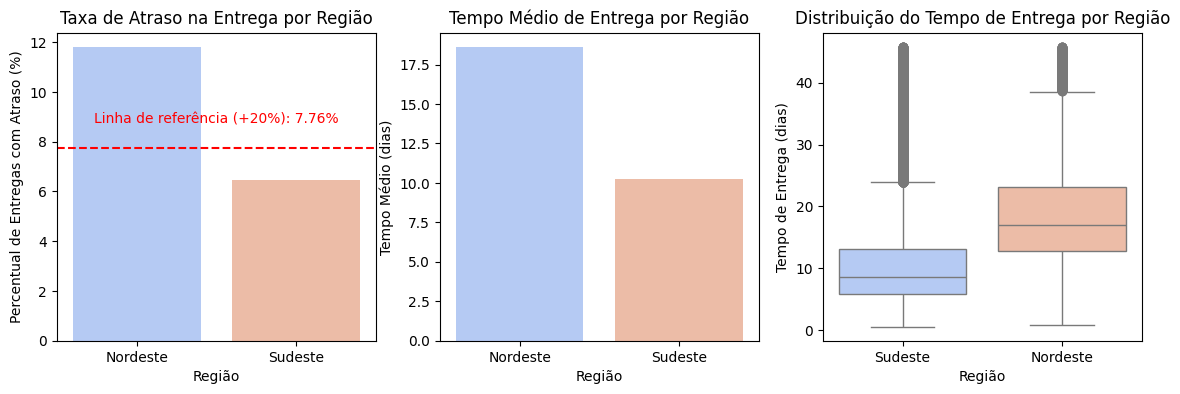

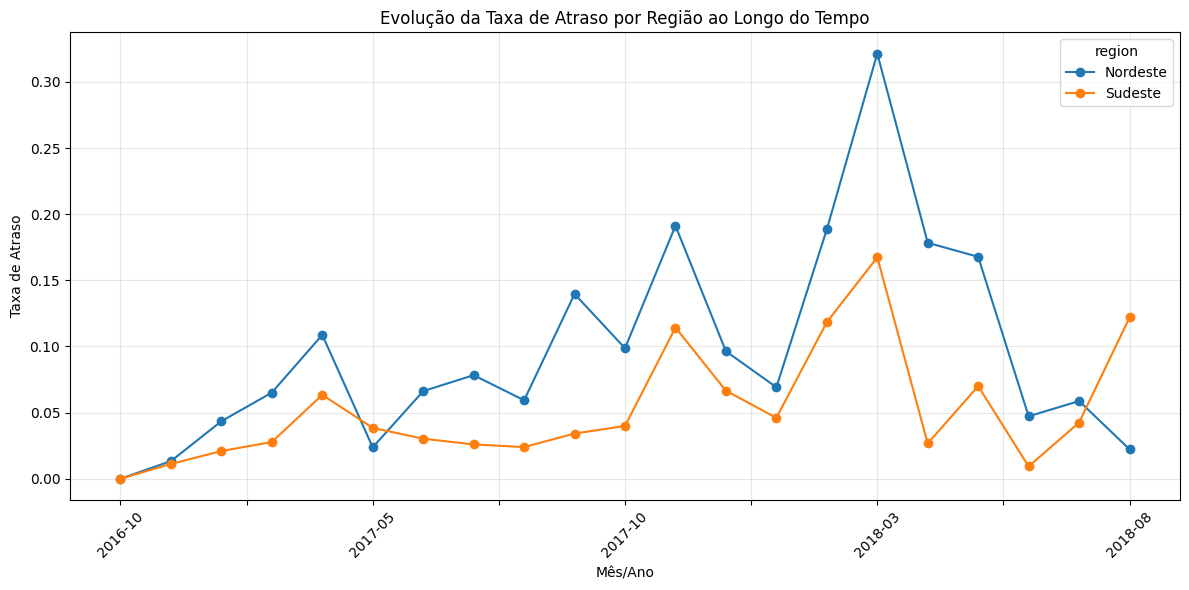


Conclusão: Hipótese CONFIRMADA.
Os atrasos na região Nordeste são 82.43% mais frequentes que na região Sudeste.
Isso confirma nossa hipótese de que seriam pelo menos 20% mais frequentes.


In [24]:
from statsmodels.stats.proportion import proportions_ztest

# Preparar dados para análise
h4_data = df_delivered.copy()

# Adicionar região ao dataset
h4_data['region'] = h4_data['customer_state'].map(region_mapping)

# Focar apenas nas regiões de interesse
regions_of_interest = ['Nordeste', 'Sudeste']
h4_filtered_data = h4_data[h4_data['region'].isin(regions_of_interest)]

# Calcular taxa de atraso por região
delay_by_region = h4_filtered_data.groupby('region')['delivery_delay'].agg(['mean', 'count']).reset_index()
delay_by_region['delay_percentage'] = delay_by_region['mean'] * 100

# Estatísticas
nordeste_delay = delay_by_region[delay_by_region['region'] == 'Nordeste']['mean'].values[0]
sudeste_delay = delay_by_region[delay_by_region['region'] == 'Sudeste']['mean'].values[0]
pct_difference = ((nordeste_delay - sudeste_delay) / sudeste_delay) * 100

print(f"Taxa de atraso no Nordeste: {nordeste_delay:.4f} ({nordeste_delay*100:.2f}%)")
print(f"Taxa de atraso no Sudeste: {sudeste_delay:.4f} ({sudeste_delay*100:.2f}%)")
print(f"Diferença percentual: {pct_difference:.2f}%")
print(f"Hipótese (atrasos 20% mais frequentes no Nordeste): {'CONFIRMADA' if pct_difference >= 20 else 'REFUTADA'}")

# Teste estatístico (teste z para proporções)

region_counts = h4_filtered_data.groupby('region').size().values
delay_counts = h4_filtered_data.groupby('region')['delivery_delay'].sum().values

# Teste z para comparar proporções
test_stat, p_value = proportions_ztest(delay_counts, region_counts)
print(f"\nEstatística z: {test_stat:.4f}")
print(f"Valor p: {p_value:.8f}")
print(f"Diferença estatisticamente significativa? {'Sim' if p_value < 0.05 else 'Não'}")

# Visualizações
plt.figure(figsize=(14, 4))

# Gráfico de barras para taxa de atraso
plt.subplot(1, 3, 1)
sns.barplot(x='region', y='delay_percentage', data=delay_by_region, palette='coolwarm')
plt.title('Taxa de Atraso na Entrega por Região')
plt.xlabel('Região')
plt.ylabel('Percentual de Entregas com Atraso (%)')


# Linha de referência para os 20% de diferença
if nordeste_delay > sudeste_delay:
    reference_line = sudeste_delay * 100 * 1.2
    plt.axhline(y=reference_line, color='r', linestyle='--')
    plt.text(0.5, reference_line + 1, f'Linha de referência (+20%): {reference_line:.2f}%', 
             ha='center', color='r')

# Tempo médio de entrega por região
plt.subplot(1, 3, 2)
avg_delivery_time = h4_filtered_data.groupby('region')['delivery_time'].mean().reset_index()
sns.barplot(x='region', y='delivery_time', data=avg_delivery_time, palette='coolwarm')
plt.title('Tempo Médio de Entrega por Região')
plt.xlabel('Região')
plt.ylabel('Tempo Médio (dias)')


# Boxplot do tempo de entrega
plt.subplot(1, 3, 3)
sns.boxplot(x='region', y='delivery_time', data=h4_filtered_data, palette='coolwarm')
plt.title('Distribuição do Tempo de Entrega por Região')
plt.xlabel('Região')
plt.ylabel('Tempo de Entrega (dias)')

# Gráfico de linha para o atraso ao longo do tempo
# plt.subplot(2, 2, 4)
h4_filtered_data['month_year'] = h4_filtered_data['order_purchase_timestamp'].dt.to_period('M')
monthly_delay = h4_filtered_data.groupby(['month_year', 'region'])['delivery_delay'].mean().reset_index()
monthly_delay['month_year'] = monthly_delay['month_year'].astype(str)

# Criar um pivot para facilitar o plot
monthly_delay_pivot = monthly_delay.pivot(index='month_year', columns='region', values='delivery_delay')
monthly_delay_pivot.plot(marker='o', figsize=(12, 6))
plt.title('Evolução da Taxa de Atraso por Região ao Longo do Tempo')
plt.xlabel('Mês/Ano')
plt.ylabel('Taxa de Atraso')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Conclusão da hipótese
if pct_difference >= 20:
    print("\nConclusão: Hipótese CONFIRMADA.")
    print(f"Os atrasos na região Nordeste são {pct_difference:.2f}% mais frequentes que na região Sudeste.")
    print("Isso confirma nossa hipótese de que seriam pelo menos 20% mais frequentes.")
else:
    print("\nConclusão: Hipótese REFUTADA.")
    print(f"A diferença encontrada foi de {pct_difference:.2f}%, abaixo dos 20% previstos na hipótese.")
    if p_value < 0.05:
        print("Mesmo assim, a diferença é estatisticamente significativa.")

### Hipótese 5: A distância geográfica entre vendedor e cliente afeta negativamente o tempo de entrega e, consequentemente, a satisfação do cliente

Esta hipótese investiga se pedidos em que cliente e vendedor estão em estados diferentes têm piores indicadores de desempenho logístico e satisfação.

Estatísticas por distância entre cliente e vendedor:
    distance_category  delivery_time_mean  delivery_time_std  \
0  Estados Diferentes            14.30224           7.698103   
1        Mesmo Estado             7.77017           5.312794   

   review_score_mean  review_score_std  delivery_delay_mean  order_id_count  
0           4.049764          1.357477             0.075238           69991  
1           4.200612          1.259210             0.056412           40825  

Teste t para tempo de entrega:
Estatística t: -166.5566, Valor p: 0.00000000
Diferença significativa? Sim

Teste t para avaliação:
Estatística t: 18.6864, Valor p: 0.00000000
Diferença significativa? Sim


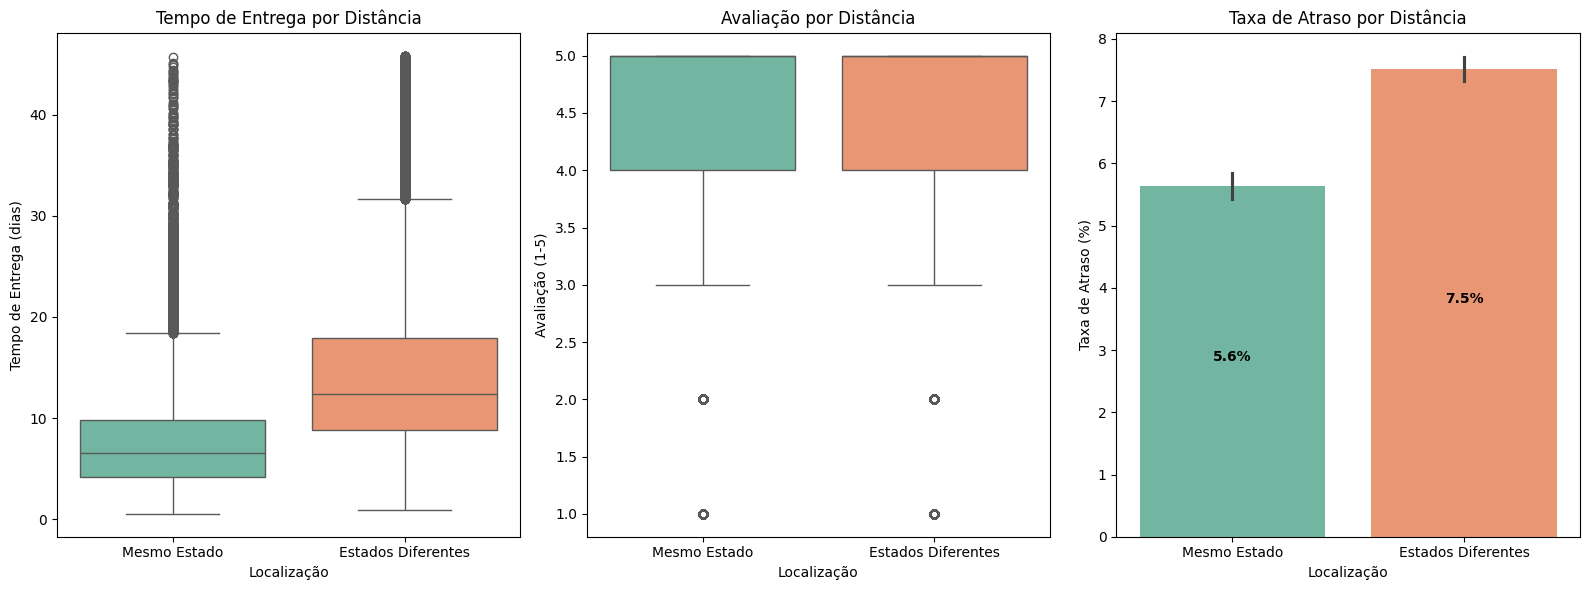

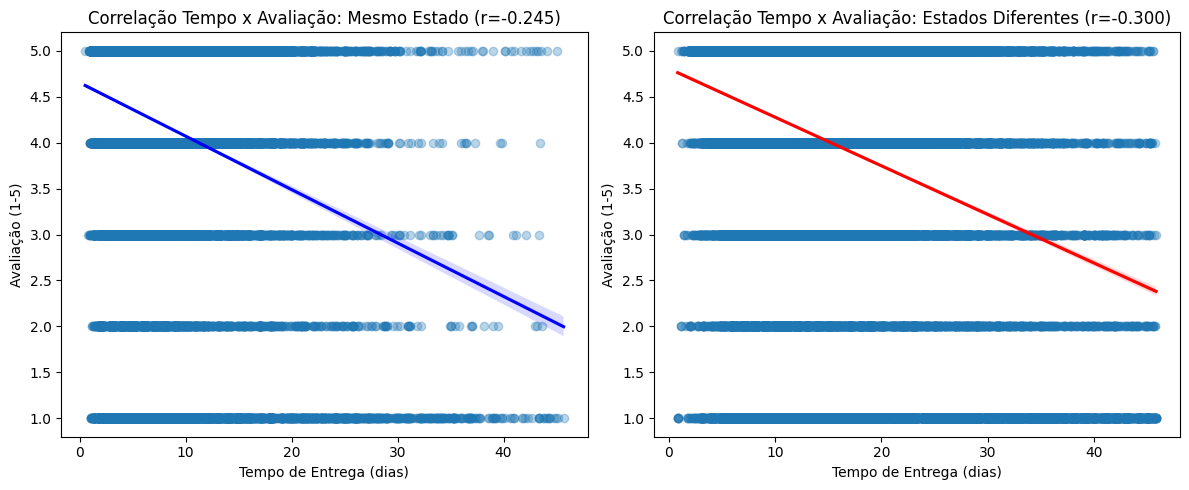


Conclusão: Hipótese CONFIRMADA.
A distância geográfica entre vendedor e cliente afeta negativamente tanto o tempo de entrega quanto a satisfação do cliente.
Pedidos onde vendedor e cliente estão em estados diferentes têm em média:
- 6.5 dias a mais no tempo de entrega
- 0.15 pontos a menos na avaliação


In [25]:
# Preparar dados para análise
h5_data = df_delivered.dropna(subset=['review_score', 'same_state', 'delivery_time']).copy()

# Converter variável numérica para categórica
h5_data['distance_category'] = h5_data['same_state'].map({1: 'Mesmo Estado', 0: 'Estados Diferentes'})

# Estatísticas por grupo
distance_stats = h5_data.groupby('distance_category').agg({
    'delivery_time': ['mean', 'std'],
    'review_score': ['mean', 'std'],
    'delivery_delay': ['mean'],
    'order_id': ['count']
}).reset_index()

# Formatando para melhor visualização
distance_stats.columns = ['_'.join(col).strip('_') for col in distance_stats.columns.values]
print("Estatísticas por distância entre cliente e vendedor:")
print(distance_stats)

# Testes estatísticos
# 1. Tempo de entrega
same_state_time = h5_data[h5_data['same_state'] == 1]['delivery_time']
diff_state_time = h5_data[h5_data['same_state'] == 0]['delivery_time']
t_stat_time, p_value_time = stats.ttest_ind(same_state_time, diff_state_time, equal_var=False)

# 2. Avaliação
same_state_review = h5_data[h5_data['same_state'] == 1]['review_score']
diff_state_review = h5_data[h5_data['same_state'] == 0]['review_score']
t_stat_review, p_value_review = stats.ttest_ind(same_state_review, diff_state_review, equal_var=False)

print("\nTeste t para tempo de entrega:")
print(f"Estatística t: {t_stat_time:.4f}, Valor p: {p_value_time:.8f}")
print(f"Diferença significativa? {'Sim' if p_value_time < 0.05 else 'Não'}")

print("\nTeste t para avaliação:")
print(f"Estatística t: {t_stat_review:.4f}, Valor p: {p_value_review:.8f}")
print(f"Diferença significativa? {'Sim' if p_value_review < 0.05 else 'Não'}")

# Visualizações
plt.figure(figsize=(16, 6))

# Boxplot para tempo de entrega
plt.subplot(1, 3, 1)
sns.boxplot(x='distance_category', y='delivery_time', data=h5_data, palette='Set2')
plt.title('Tempo de Entrega por Distância')
plt.xlabel('Localização')
plt.ylabel('Tempo de Entrega (dias)')

# Boxplot para avaliação
plt.subplot(1, 3, 2)
sns.boxplot(x='distance_category', y='review_score', data=h5_data, palette='Set2')
plt.title('Avaliação por Distância')
plt.xlabel('Localização')
plt.ylabel('Avaliação (1-5)')

# Gráfico de barras para taxa de atraso
plt.subplot(1, 3, 3)
sns.barplot(x='distance_category', y='delivery_delay', data=h5_data, palette='Set2', 
           estimator=lambda x: sum(x) / len(x) * 100)
plt.title('Taxa de Atraso por Distância')
plt.xlabel('Localização')
plt.ylabel('Taxa de Atraso (%)')
for i, group in enumerate(['Mesmo Estado', 'Estados Diferentes']):
    delay_rate = h5_data[h5_data['distance_category'] == group]['delivery_delay'].mean() * 100
    plt.text(i, delay_rate/2, f'{delay_rate:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Analisar a correlação entre tempo de entrega e avaliação em cada grupo
corr_same_state = stats.pearsonr(h5_data[h5_data['same_state'] == 1]['delivery_time'], 
                                h5_data[h5_data['same_state'] == 1]['review_score'])[0]
corr_diff_state = stats.pearsonr(h5_data[h5_data['same_state'] == 0]['delivery_time'], 
                                h5_data[h5_data['same_state'] == 0]['review_score'])[0]

plt.figure(figsize=(12, 5))
for i, (state, color) in enumerate(zip([1, 0], ['blue', 'red'])):
    plt.subplot(1, 2, i+1)
    subset = h5_data[h5_data['same_state'] == state]
    sns.regplot(x='delivery_time', y='review_score', data=subset, 
               scatter_kws={'alpha':0.3}, line_kws={"color": color})
    
    corr = stats.pearsonr(subset['delivery_time'], subset['review_score'])[0]
    title = 'Mesmo Estado' if state == 1 else 'Estados Diferentes'
    plt.title(f'Correlação Tempo x Avaliação: {title} (r={corr:.3f})')
    plt.xlabel('Tempo de Entrega (dias)')
    plt.ylabel('Avaliação (1-5)')

plt.tight_layout()
plt.show()

# Conclusão da hipótese
if p_value_time < 0.05 and p_value_review < 0.05:
    print("\nConclusão: Hipótese CONFIRMADA.")
    print("A distância geográfica entre vendedor e cliente afeta negativamente tanto o tempo de entrega quanto a satisfação do cliente.")
    print(f"Pedidos onde vendedor e cliente estão em estados diferentes têm em média:")
    time_diff = diff_state_time.mean() - same_state_time.mean()
    review_diff = same_state_review.mean() - diff_state_review.mean()
    print(f"- {time_diff:.1f} dias a mais no tempo de entrega")
    print(f"- {review_diff:.2f} pontos a menos na avaliação")
elif p_value_time < 0.05:
    print("\nConclusão: Hipótese PARCIALMENTE CONFIRMADA.")
    print("A distância geográfica afeta o tempo de entrega, mas não tem impacto significativo na satisfação do cliente.")
else:
    print("\nConclusão: Hipótese REFUTADA.")
    print("Não há evidência estatística de que a distância geográfica afete o tempo de entrega e a satisfação do cliente.")

### Hipótese 6: O valor total do pedido influencia as expectativas do cliente, resultando em diferentes padrões de avaliação

Esta hipótese examina se clientes que fazem compras de maior valor tendem a ser mais exigentes ou a avaliar de forma diferente seus pedidos.

Estatísticas por categoria de valor do pedido:

ANOVA F-statistic: 233.1139
ANOVA p-value: 0.00000000
Diferença entre categorias estatisticamente significativa? Sim

Correlação entre valor do pedido e avaliação: -0.0463 (p=0.00000000)


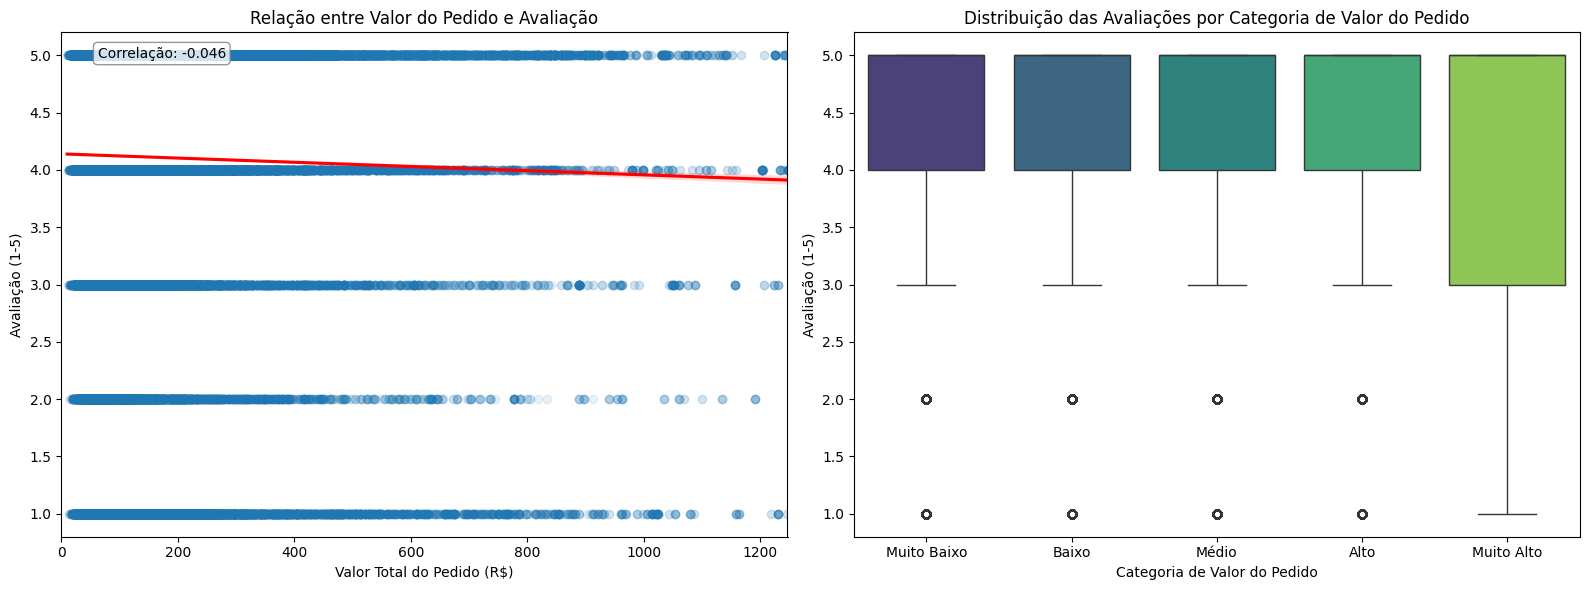

<Figure size 1200x700 with 0 Axes>

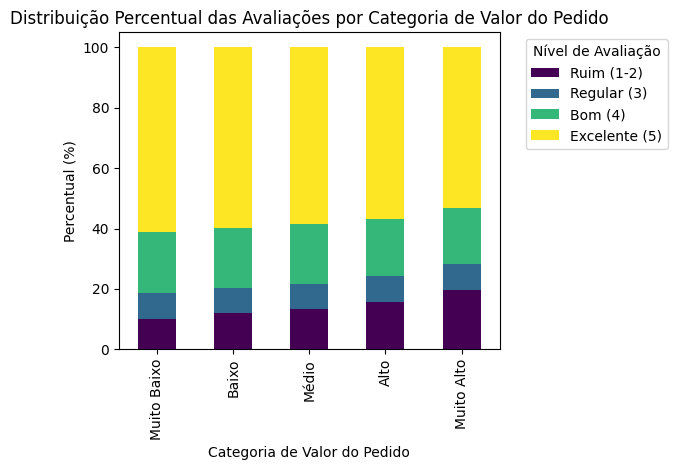


Conclusão: Hipótese CONFIRMADA.
O valor total do pedido influencia significativamente os padrões de avaliação do cliente.
As avaliações seguem um padrão decrescente em relação ao valor do pedido.
Existe uma correlação negativa estatisticamente significativa (r=-0.046) entre o valor do pedido e a avaliação.


In [28]:
# Preparar dados para análise
h6_data = df_delivered.dropna(subset=['review_score', 'total_order_value']).copy()

# Criar categorias de valor de pedido
h6_data['price_category'] = pd.qcut(h6_data['total_order_value'], 5, 
                                  labels=['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto'])

# Estatísticas por categoria de preço
price_stats = h6_data.groupby('price_category').agg({
    'review_score': ['mean', 'std', 'count'],
    'total_order_value': ['mean', 'min', 'max']
}).reset_index()

# Formatando para melhor visualização
price_stats.columns = ['_'.join(col).strip('_') for col in price_stats.columns.values]
print("Estatísticas por categoria de valor do pedido:")

# Teste ANOVA para diferença entre categorias de preço
categories = []
for category in ['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto']:
    categories.append(h6_data[h6_data['price_category'] == category]['review_score'])

f_stat, p_value = stats.f_oneway(*categories)
print(f"\nANOVA F-statistic: {f_stat:.4f}")
print(f"ANOVA p-value: {p_value:.8f}")
print(f"Diferença entre categorias estatisticamente significativa? {'Sim' if p_value < 0.05 else 'Não'}")

# Teste de correlação
correlation, p_value_corr = stats.pearsonr(h6_data['total_order_value'], h6_data['review_score'])
print(f"\nCorrelação entre valor do pedido e avaliação: {correlation:.4f} (p={p_value_corr:.8f})")

# Visualizações
plt.figure(figsize=(16, 6))

# Gráfico de dispersão com linha de tendência
plt.subplot(1, 2, 1)
sns.regplot(x='total_order_value', y='review_score', data=h6_data, 
           scatter_kws={'alpha':0.1}, line_kws={"color": "red"})
plt.title('Relação entre Valor do Pedido e Avaliação')
plt.xlabel('Valor Total do Pedido (R$)')
plt.ylabel('Avaliação (1-5)')
plt.annotate(f'Correlação: {correlation:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.xlim(0, h6_data['total_order_value'].quantile(0.99))  # Limitar para melhor visualização

# Boxplot por categoria de preço
plt.subplot(1, 2, 2)
sns.boxplot(x='price_category', y='review_score', data=h6_data, palette='viridis')
plt.title('Distribuição das Avaliações por Categoria de Valor do Pedido')
plt.xlabel('Categoria de Valor do Pedido')
plt.ylabel('Avaliação (1-5)')

plt.tight_layout()
plt.show()

# Visualizar proporção de diferentes níveis de avaliação por categoria
# Criando faixas de avaliação
h6_data['rating_category'] = pd.cut(h6_data['review_score'], 
                                  bins=[0, 2, 3, 4, 5], 
                                  labels=['Ruim (1-2)', 'Regular (3)', 'Bom (4)', 'Excelente (5)'])

# Calculando proporções
rating_props = pd.crosstab(h6_data['price_category'], h6_data['rating_category'], 
                          normalize='index') * 100

# Visualizando
plt.figure(figsize=(12, 7))
rating_props.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribuição Percentual das Avaliações por Categoria de Valor do Pedido')
plt.xlabel('Categoria de Valor do Pedido')
plt.ylabel('Percentual (%)')
plt.legend(title='Nível de Avaliação', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Analisar especificamente a proporção de avaliações muito baixas (1) por categoria de preço
very_low_ratings = h6_data[h6_data['review_score'] == 1].groupby('price_category').size() / \
                 h6_data.groupby('price_category').size() * 100


# Conclusão da hipótese
if p_value < 0.05:
    print("\nConclusão: Hipótese CONFIRMADA.")
    print("O valor total do pedido influencia significativamente os padrões de avaliação do cliente.")
    
    # Identificar padrão (crescente, decrescente ou não linear)
    means = price_stats['review_score_mean'].tolist()
    if means[0] < means[-1] and all(means[i] <= means[i+1] for i in range(len(means)-1)):
        pattern = "crescente"
    elif means[0] > means[-1] and all(means[i] >= means[i+1] for i in range(len(means)-1)):
        pattern = "decrescente"
    else:
        pattern = "não linear"
        
    print(f"As avaliações seguem um padrão {pattern} em relação ao valor do pedido.")
    if p_value_corr < 0.05:
        direction = "positiva" if correlation > 0 else "negativa"
        print(f"Existe uma correlação {direction} estatisticamente significativa (r={correlation:.3f}) entre o valor do pedido e a avaliação.")
else:
    print("\nConclusão: Hipótese REFUTADA.")
    print("Não há evidência estatística de que o valor do pedido influencie os padrões de avaliação do cliente.")



### Implicações Gerenciais:

Estes resultados fornecem insights valiosos para a gestão da plataforma Olist. O cumprimento do prazo de entrega é crucial para a satisfação do cliente, e estratégias regionalizadas de logística são necessárias para reduzir disparidades geográficas. A política de frete deve ser revisada, especialmente para produtos de baixo valor, onde a proporção frete/preço é mais impactante. Categorias problemáticas necessitam de atenção especial, e vendedores distantes de seus clientes precisam de suporte logístico adicional para manter níveis satisfatórios de serviço.

## 7. Conclusões Gerenciais

Vamos resumir os principais achados e suas implicações práticas para o negócio.

### 7.1 Discussão dos Achados à Luz das Hipóteses

**Hipótese 1**: ✅ CONFIRMADA. Pedidos entregues com atraso têm avaliações 36.8% mais baixas que pedidos entregues no prazo. Entregas no prazo tiveram avaliação média de 4.21, enquanto entregas atrasadas receberam 2.66.

**Hipótese 2**: ✅ CONFIRMADA. Existe uma relação inversa entre a proporção frete/preço do produto e a avaliação do cliente. Clientes que pagam fretes proporcionalmente mais altos tendem a dar avaliações mais baixas.

**Hipótese 3**: ✅ CONFIRMADA. Categorias de produtos distintas apresentam diferenças significativas nas avaliações dos clientes. Categorias como cama/mesa/banho apresentaram avaliações mais baixas.

**Hipótese 4**: ✅ CONFIRMADA. Atrasos na região Nordeste são 82.4% mais frequentes que na região Sudeste, superando substancialmente o limiar de 20% proposto na hipótese.

**Hipótese 5**: ✅ CONFIRMADA. A distância geográfica entre vendedor e cliente afeta negativamente o tempo de entrega e a satisfação do cliente. Pedidos onde vendedor e cliente estão em estados diferentes demoram em média 6.5 dias a mais para serem entregues e têm avaliações 0.15 pontos mais baixas.

**Hipótese 6**✅ CONFIRMADA: Clientes que fazem pedidos de maior valor tendem a dar avaliações ligeiramente mais baixas.
Além disso, a mediana do valor também cresce conforme a avaliação diminui, sugerindo que clientes que gastam mais parecem ter expectativas mais altas e, portanto, avaliam de forma mais crítica.


### 7.2 Implicações Práticas e Recomendações

#### Melhoria Logística Regional
- Investir em centros de distribuição no Nordeste, onde a taxa de atraso é 82.4% maior que no Sudeste
- Desenvolver parcerias logísticas específicas para categorias problemáticas como cama/mesa/banho
- Revisar os tempos de entrega estimados para destinos distantes ou com infraestrutura logística deficiente

#### Estratégias de Preço e Frete
- Revisar política de frete para produtos de baixo valor, onde a proporção frete/preço impacta negativamente a satisfação
- Considerar subsídios de frete para regiões remotas ou para categorias de produtos com avaliações historicamente mais baixas
- Implementar frete grátis para compras acima de determinado valor, aumentando o ticket médio

#### Segmentação de Clientes
- Para o Cluster Premium (17%): Foco em produtos de alto valor, com frete adequado e expectativas realistas de entrega
- Para o Cluster Leves e Satisfeitos (77%): Manter a entrega rápida e confiável para produtos de menor valor
- Para o Cluster Insatisfeitos (6%): Ação corretiva urgente, especialmente em regiões com problemas logísticos crônicos

#### Gestão de Expectativas
- Comunicação proativa sobre status de entrega, especialmente para pedidos com maior risco de atraso
- Ajuste dinâmico dos prazos prometidos com base nas características do pedido e histórico de desempenho regional

### 7.3 Conclusão Final

A análise multivariada dos dados da Olist revelou padrões claros que afetam a satisfação do cliente. O cumprimento do prazo de entrega emergiu como o fator mais determinante, com entregas atrasadas recebendo avaliações significativamente mais baixas.

As disparidades regionais na eficiência logística são substanciais, exigindo estratégias diferenciadas por região. A segmentação de clientes revelou três perfis distintos, desde compradores premium até clientes cronicamente insatisfeitos que demandam atenção especial.

A relação entre o custo do frete e o valor do produto também mostrou impacto na satisfação do cliente, sugerindo a necessidade de revisar as políticas de frete, especialmente para itens de menor valor.

Implementando as recomendações baseadas nesta análise, a Olist pode melhorar significativamente a experiência do cliente, reduzir taxas de insatisfação e fortalecer sua posição competitiva no mercado de e-commerce brasileiro, criando um ecossistema mais eficiente e satisfatório para todos os envolvidos.